# Cell 1
# Circos-Style Money Flow Chord Diagram

This notebook builds a self-contained Circos-style chord diagram from Accumulation Score time series in a local database.

Constraints honored:
- No project modules are imported or modified.
- Database access is read-only (SELECT-only).
- No files are written or mutated; all outputs are in-notebook only.


In [ ]:
# Ticker groups (from ticker_dictionary.py)
from pathlib import Path
import importlib.util


def _load_ticker_dictionary():
    candidates = [
        Path.cwd() / "ticker_dictionary.py",
        Path.cwd() / "Special_tools" / "ticker_dictionary.py",
    ]
    for path in candidates:
        if path.exists():
            spec = importlib.util.spec_from_file_location("ticker_dictionary", path)
            if spec and spec.loader:
                module = importlib.util.module_from_spec(spec)
                spec.loader.exec_module(module)
                return module
    raise FileNotFoundError("ticker_dictionary.py not found in current or Special_tools directory")


ticker_dict = _load_ticker_dictionary()
SECTOR_ZOOM_MAP = ticker_dict.SECTOR_ZOOM_MAP
SECTOR_CORE_TICKERS = list(SECTOR_ZOOM_MAP["SECTOR_CORE"].keys())
SECTOR_SUMMARY_TICKERS = list(SECTOR_ZOOM_MAP["SECTOR_SUMMARY"].keys())
GLOBAL_MACRO_TICKERS = list(SECTOR_ZOOM_MAP["GLOBAL_MACRO"].keys())
COMMODITIES_TICKERS = list(SECTOR_ZOOM_MAP["COMMODITIES"].keys())
MAG8_TICKERS = list(SECTOR_ZOOM_MAP["MAG8"]["MAG8"])
SPECULATIVE_TICKERS = list(getattr(ticker_dict, "SPECULATIVE_TICKERS", []))
CRYPTO_TICKERS = list(getattr(ticker_dict, "CRYPTO_TICKERS", []))

TICKER_TYPE = ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8",]

TICKER_TYPE_OPTIONS = ["SECTOR", "SUMMARY", "GLOBAL", "COMMODITIES", "MAG8", "SPECULATIVE", "CRYPTO", "ALL"] # Do not edit

def _normalize_ticker_types(value):
    if value is None:
        return []
    if isinstance(value, (list, tuple, set)):
        return [str(v).upper() for v in value]
    return [str(value).upper()]

_selected_types = _normalize_ticker_types(TICKER_TYPE)
if not _selected_types:
    _selected_types = ["ALL"]
unknown_types = [t for t in _selected_types if t not in TICKER_TYPE_OPTIONS]
if unknown_types:
    raise ValueError(f"Unknown TICKER_TYPE: {unknown_types}")
if "ALL" in _selected_types:
    _selected_types = [t for t in TICKER_TYPE_OPTIONS if t != "ALL"]

ENABLED_GROUPS = {
    "GLOBAL_MACRO": "GLOBAL" in _selected_types,
    "MAG8": "MAG8" in _selected_types,
    "SECTOR_SUMMARY": "SUMMARY" in _selected_types,
    "SECTOR_CORE": "SECTOR" in _selected_types,
    "COMMODITIES": "COMMODITIES" in _selected_types,
    "SPECULATIVE": "SPECULATIVE" in _selected_types,
    "CRYPTO": "CRYPTO" in _selected_types,
}

# Controls
END_DATE = None                         # End of window; None = auto-detect max date in DB
FLOW_PERIOD_DAYS = 5                   # Trading-day window used for flows (start->end inside this window)
TOP_K_WINNERS =12                       # Max winners by demand (positive delta) to include
TOP_K_LOSERS = 12                        # Max losers by supply (negative delta) to include
MIN_EDGE_FLOW = 0.0                     # Drop edges smaller than this flow (pre-strand)
DISTRIBUTION_MODE = "demand_weighted"   # "equal" or "demand_weighted" split from sources to winners

# Chord + ring layout
METRIC_BAND_MODE = "proportional"       # "equal" = same band width per metric; "proportional" = band width by flow
MAX_EDGES_PER_METRIC = 80              # cap edges per metric to keep plot readable
EDGE_RIBBON_SPLITS = 25                 # split each edge into N thin ribbons (approx density)
EDGE_RIBBON_MAX = 60                    # cap ribbons per edge (perf)
CHORD_ARC_FRACTION = 0.5                # fraction of ticker arc reserved for chord endpoints
CHORD_RADIUS = 0.78                     # inner radius for chord ribbons
TIME_SLICE_BINS = 30                     # number of time slices per outer ring
RING_BASE_THICKNESS = 0.005             # minimum ring thickness
RING_THICKNESS_SCALE = 0.1             # added thickness scaled by magnitude
RING_GAP = 0.01                         # gap between metric rings
BAND_GAP_FRAC = 0.02                    # gap between metric bands within a ticker
DIR_GAP_FRAC = 0.02                     # gap between outflow/inflow halves inside a band
CATEGORY_GAP_DEG = 1                    # degrees; category block gap (0 = uniform spacing)

# Fanned chord layout config
RIBBON_MIN_WIDTH_RAD = {                # minimum ribbon arc width in radians (per-metric)
    'accum': 0.002,
    'short': 0.002,
    'lit': 0.002,
    'finra_buy': 0.002,
    'vwbr_z': 0.002,
}
RIBBON_GAP_RAD = 0.002                  # gap between ribbons in radians
RIBBON_WIDTH_SCALE_BY_FLOW = True       # if True, ribbon width scales with flow; if False, all equal
RIBBON_CENTERED = True                  # if True, ribbons fan out from center; if False, from edge
RIBBON_CENTER_OFFSET = {                # per-metric center offset in radians (positive = clockwise)
    'accum': 0.0,                       # accumulation stays centered
    'short': 0.5,                       # short offset (adjust as needed)
    'lit': -0.5,                        # lit offset (adjust as needed)
    'finra_buy': 0.0,                   # finra buy offset
    'vwbr_z': 0.0,                      # finra buy z offset
}

# Render quality (performance vs fidelity)
RENDER_MODE = "balanced"  # "fast", "balanced", "quality"
CHORD_FILL_ALPHA = 0.55
CHORD_LINE_ALPHA = 0.8
CHORD_COLOR_SOFTEN = 0.25  # blend toward background to reduce saturation
if RENDER_MODE == "fast":
    USE_GRADIENT_FILL = False
    CHORD_GRADIENT_STEPS = 8
    CHORD_ARC_POINTS = 8
    CHORD_CURVE_POINTS = 30
elif RENDER_MODE == "quality":
    USE_GRADIENT_FILL = True
    CHORD_GRADIENT_STEPS = 32
    CHORD_ARC_POINTS = 18
    CHORD_CURVE_POINTS = 70
else:
    USE_GRADIENT_FILL = True
    CHORD_GRADIENT_STEPS = 18
    CHORD_ARC_POINTS = 12
    CHORD_CURVE_POINTS = 50
TIME_FADE_MIN_ALPHA = 0.15       # Oldest ribbon alpha
TIME_FADE_MAX_ALPHA = 0.85       # Newest ribbon alpha
TIME_FADE_POWER = 1.0            # Curve shaping (1=linear)

# Layer toggles (enable/disable chord and ring layers)
SHOW_ACCUM_FLOW = False             # Accumulation score chords
SHOW_LIT_FLOW = False               # Lit buy/sell chords
SHOW_SHORT_NET_FLOW = False         # Net = short_buy_sum - short_sell_sum (raw volumes)
SHOW_VWBR_Z = True                 # Finra buy-volume z-score chords (negative/positive)
SHOW_FINRA_FLOW = False              # Finra buy-volume chords

SHOW_VOLUME_RING = True             # Outer metric rings
FIGURE_SIZE = (20, 20)          # Width, height in inches
PLOT_CENTER_X = 0.45            # Plot center (figure fraction)
PLOT_CENTER_Y = 0.55
MAIN_AX_SIZE = 0.82             # Square axes size (figure fraction)
SHOW_TIME_FADE_CHORDS = True    # Fade chord alpha by recency

WATERMARK_PATH = r'C:\\Users\\fvign\\Dropbox\\Vscode\\darkpool\\cowwbell_waterrmark.png'
WATERMARK_WIDTH = 0.08        # Figure fraction
WATERMARK_ALPHA = 0.6
FIGURE_SCALE = min(FIGURE_SIZE) / 12.0
TITLE_FONTSIZE = 14 * FIGURE_SCALE
SUBTITLE_FONTSIZE = 10 * FIGURE_SCALE
TICKER_FONTSIZE = 9 * FIGURE_SCALE
LEGEND_TITLE_FONTSIZE = 10 * FIGURE_SCALE
LEGEND_LABEL_FONTSIZE = 8 * FIGURE_SCALE
RING_TITLE_FONTSIZE = 9 * FIGURE_SCALE
RING_LABEL_FONTSIZE = 7 * FIGURE_SCALE
TABLE_FONTSIZE = 9 * FIGURE_SCALE
LEGEND_LINEWIDTH = 4 * FIGURE_SCALE
TABLE_COL1_WIDTH = 25         # Table column widths (characters)
TABLE_COL2_WIDTH = 20
TABLE_COL3_WIDTH = 20


In [2]:
# Cell 2 – DB discovery & connection helpers
from pathlib import Path
import duckdb
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

def find_db_candidates():
    root = Path('.').resolve()
    search_dirs = [
        root / 'data',
        root / 'darkpool_analysis' / 'data',
        root.parent / 'darkpool_analysis' / 'data',  # Parent directory for Special_tools
        root,
    ]
    patterns = ['*.duckdb', '*.db', '*.sqlite', '*.sqlite3']
    candidates = []
    for d in search_dirs:
        if d.is_dir():
            for pat in patterns:
                candidates.extend(d.glob(pat))
    seen = set()
    unique = []
    for p in candidates:
        rp = p.resolve()
        if rp not in seen:
            seen.add(rp)
            unique.append(p)
    unique.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return unique

def connect_db(db_path):
    db_path = Path(db_path)
    suffix = db_path.suffix.lower()
    errors = []

    def try_duckdb():
        import duckdb
        return duckdb.connect(database=str(db_path), read_only=True), 'duckdb'

    def try_sqlite():
        import sqlite3
        con = sqlite3.connect(str(db_path))
        con.row_factory = sqlite3.Row
        return con, 'sqlite'

    if suffix == '.duckdb':
        attempts = [try_duckdb, try_sqlite]
    else:
        attempts = [try_sqlite, try_duckdb]

    for fn in attempts:
        try:
            return fn()
        except Exception as e:
            errors.append(f'{fn.__name__}: {e}')
    raise RuntimeError('Unable to open database. ' + '; '.join(errors))

def get_tables(conn, db_type):
    if db_type == 'duckdb':
        return [r[0] for r in conn.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='main'").fetchall()]
    else:
        return [r[0] for r in conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()]

def get_columns(conn, db_type, table):
    if db_type == 'duckdb':
        return [r[0] for r in conn.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name='{table}'").fetchall()]
    else:
        return [r[1] for r in conn.execute(f"PRAGMA table_info('{table}')").fetchall()]

def pick_column(columns, candidates):
    cols_lower = {c.lower(): c for c in columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

def quote_ident(name):
    return f'"{name}"'

# ---------------------------------------------------------------------------
# Column name candidates for auto-detection
# ---------------------------------------------------------------------------
# Priority order: daily_metrics has accumulation scores
TABLE_CANDIDATES = ['daily_metrics', 'scanner_daily_metrics', 'darkpool_metrics', 'metrics', 'darkpool', 'accumulation']
TICKER_COL_CANDIDATES = ['ticker', 'symbol', 'stock', 'name']
DATE_COL_CANDIDATES = ['date', 'trade_date', 'dt', 'timestamp']
ACCUM_COL_CANDIDATES = ['accumulation_score_display', 'accum_score_display', 
                        'accumulation_score', 'accum_score', 'accumulation', 'accum']

# Volume column candidates
SHORT_BUY_CANDIDATES = ['finra_buy_volume', 'short_buy_volume', 'short_buy', 'short_buy_vol']
SHORT_SELL_CANDIDATES = ['short_sell_volume', 'short_sell', 'short_sell_vol']
LIT_BUY_CANDIDATES = ['lit_buy_volume', 'lit_buy', 'lit_buy_vol']
LIT_SELL_CANDIDATES = ['lit_sell_volume', 'lit_sell', 'lit_sell_vol']
OTC_VOLUME_CANDIDATES = ['otc_off_exchange_volume', 'otc_volume', 'dark_volume']
LIT_TOTAL_CANDIDATES = ['lit_total_volume', 'lit_volume', 'lit_total']
FINRA_BUY_CANDIDATES = ['finra_buy_volume', 'finra_buy', 'finra_buy_vol']
FINRA_BUY_Z_CANDIDATES = ['finra_buy_volume_z', 'finra_buy_z', 'finra_buy_vol_z']

# ---------------------------------------------------------------------------
# Discover & connect
# ---------------------------------------------------------------------------
db_candidates = find_db_candidates()

print('DB candidates (newest first):')
for p in db_candidates:
    print(' -', p)

if not db_candidates:
    print('No database files found under ./data or ./darkpool_analysis/data.')
    raise SystemExit

DB_PATH = db_candidates[0]
print(f'Using DB: {DB_PATH}')

conn, db_type = connect_db(DB_PATH)
print(f'Connected via {db_type}')

# ---------------------------------------------------------------------------
# Auto-detect table and column names
# ---------------------------------------------------------------------------
tables = get_tables(conn, db_type)
print(f'Tables found: {tables}')

SELECT_TABLE = None
for cand in TABLE_CANDIDATES:
    matching = [t for t in tables if t.lower() == cand.lower()]
    if matching:
        SELECT_TABLE = matching[0]
        break
if not SELECT_TABLE and tables:
    SELECT_TABLE = tables[0]

if not SELECT_TABLE:
    print('No suitable table found in database.')
    conn.close()
    raise SystemExit

print(f'Using table: {SELECT_TABLE}')

columns = get_columns(conn, db_type, SELECT_TABLE)
print(f'Columns in {SELECT_TABLE}: {columns}')

TICKER_COL = pick_column(columns, TICKER_COL_CANDIDATES)
DATE_COL = pick_column(columns, DATE_COL_CANDIDATES)
ACCUM_COL = pick_column(columns, ACCUM_COL_CANDIDATES)

if not TICKER_COL:
    print(f'Could not find ticker column. Available: {columns}')
    conn.close()
    raise SystemExit
if not DATE_COL:
    print(f'Could not find date column. Available: {columns}')
    conn.close()
    raise SystemExit
if not ACCUM_COL:
    print(f'Could not find accumulation column. Available: {columns}')
    conn.close()
    raise SystemExit

print(f'Column mapping: ticker={TICKER_COL}, date={DATE_COL}, accum={ACCUM_COL}')

conn.close()

DB candidates (newest first):
 - C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Using DB: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Connected via duckdb
Tables found: ['composite_signal', 'daily_metrics', 'finra_otc_weekly_raw', 'finra_short_daily_raw', 'index_constituent_short_agg_daily', 'lit_direction_daily', 'options_premium_daily', 'options_premium_summary', 'polygon_daily_agg_raw', 'polygon_equity_trades_raw', 'polygon_ingestion_state']
Using table: daily_metrics
Columns in daily_metrics: ['date', 'symbol', 'log_buy_sell', 'short_volume', 'short_exempt_volume', 'short_total_volume', 'short_sell_volume', 'short_ratio', 'short_ratio_z', 'short_buy_sell_ratio', 'short_buy_sell_ratio_z', 'combined_ratio', 'vw_flow', 'vw_flow_z', 'finra_buy_volume', 'finra_buy_volume_z', 'short_ratio_denominator_type', 'short_ratio_denominator_value', 'short_ratio_source', 'lit_buy_volume', 'lit_sell_volume', 'lit_total_volume', 'lit_b

In [3]:
# Cell 4
def build_ticker_universe():
    seen = set()
    ordered = []
    categories = {}
    enabled = globals().get("ENABLED_GROUPS", {})
    group_defs = [
        ("GLOBAL_MACRO", globals().get("GLOBAL_MACRO_TICKERS", [])),
        ("MAG8", globals().get("MAG8_TICKERS", [])),
        ("SECTOR_SUMMARY", globals().get("SECTOR_SUMMARY_TICKERS", [])),
        ("SECTOR_CORE", globals().get("SECTOR_CORE_TICKERS", [])),
        ("COMMODITIES", globals().get("COMMODITIES_TICKERS", [])),
        ("SPECULATIVE", globals().get("SPECULATIVE_TICKERS", [])),
        ("CRYPTO", globals().get("CRYPTO_TICKERS", [])),
    ]
    for group_name, tickers in group_defs:
        if not enabled.get(group_name, True):
            continue
        for t in tickers:
            if t not in seen:
                seen.add(t)
                ordered.append(t)
                categories[t] = group_name
    return ordered, categories


ticker_order, ticker_category = build_ticker_universe()
print("Ticker universe size:", len(ticker_order))
print("Enabled groups:", {k: v for k, v in ENABLED_GROUPS.items()})
ticker_list = [t.upper() for t in ticker_order]
import re

conn, DB_TYPE = connect_db(DB_PATH)

if DB_TYPE == 'duckdb':
    date_expr = f"CAST({quote_ident(DATE_COL)} AS DATE)"
    accum_expr = f"{quote_ident(ACCUM_COL)}"
else:
    date_expr = f"DATE({quote_ident(DATE_COL)})"
    accum_expr = f"{quote_ident(ACCUM_COL)}"

placeholders = ','.join(['?'] * len(ticker_list))
query = (
    f"SELECT UPPER({quote_ident(TICKER_COL)}) AS ticker, "
    f"{date_expr} AS date, {accum_expr} AS accumulation_score "
    f"FROM {quote_ident(SELECT_TABLE)} "
    f"WHERE UPPER({quote_ident(TICKER_COL)}) IN ({placeholders})"
)

print(f"Using accumulation table: {SELECT_TABLE} (ticker={TICKER_COL}, date={DATE_COL}, accum={ACCUM_COL})")

try:
    if DB_TYPE == 'duckdb':
        df_raw = conn.execute(query, ticker_list).df()
    else:
        df_raw = pd.read_sql_query(query, conn, params=ticker_list)
finally:
    conn.close()

if df_raw.empty:
    print('No data returned for the specified tickers.')
    raise SystemExit

print("Accumulation rows loaded:", len(df_raw))
print("Accumulation table date range:", df_raw["date"].min(), "->", df_raw["date"].max())
print("Accumulation raw sample:", df_raw["accumulation_score"].head(5).tolist())
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce').dt.date
df_raw['ticker'] = df_raw['ticker'].str.upper()

def fetch_accum_column(accum_col_name):
    conn, db_type = connect_db(DB_PATH)
    try:
        if db_type == 'duckdb':
            date_expr = f"CAST({quote_ident(DATE_COL)} AS DATE)"
        else:
            date_expr = f"DATE({quote_ident(DATE_COL)})"
        query = (
            f"SELECT UPPER({quote_ident(TICKER_COL)}) AS ticker, "
            f"{date_expr} AS date, {quote_ident(accum_col_name)} AS accumulation_score "
            f"FROM {quote_ident(SELECT_TABLE)} "
            f"WHERE UPPER({quote_ident(TICKER_COL)}) IN ({placeholders})"
        )
        if db_type == 'duckdb':
            return conn.execute(query, ticker_list).df()
        return pd.read_sql_query(query, conn, params=ticker_list)
    finally:
        conn.close()

def normalize_accum_df(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
    df['ticker'] = df['ticker'].str.upper()
    df['accumulation_score'] = df['accumulation_score'].apply(parse_accum)
    return df.dropna(subset=['date', 'accumulation_score'])

def parse_accum(value):
    if value is None:
        return np.nan
    if isinstance(value, (int, float, np.number)):
        if np.isnan(value):
            return np.nan
        return float(value)
    s = str(value).strip()
    if not s:
        return np.nan
    s = s.replace('%', '').replace(',', '')
    m = re.search(r'[-+]?\d+\.?\d*', s)
    return float(m.group(0)) if m else np.nan

df_raw = normalize_accum_df(df_raw)
ACCUM_COL_SELECTED = ACCUM_COL
if df_raw.empty:
    print('Primary accumulation column returned no usable values; trying fallbacks...')
    conn, db_type = connect_db(DB_PATH)
    try:
        cols = get_columns(conn, db_type, SELECT_TABLE)
    finally:
        conn.close()
    candidates = []
    for cand in [
        'accumulation_score_display', 'accum_score_display',
        'accumulation_score', 'accum_score', 'accumulation', 'accum'
    ]:
        col = pick_column(cols, [cand])
        if col and col not in candidates:
            candidates.append(col)
    candidates = [c for c in candidates if c != ACCUM_COL]
    print('Accumulation fallback candidates:', candidates)
    for col in candidates:
        print('Trying accumulation column:', col)
        df_try = fetch_accum_column(col)
        print('Fallback rows loaded:', len(df_try))
        print('Fallback raw sample:', df_try['accumulation_score'].head(5).tolist())
        df_try = normalize_accum_df(df_try)
        if not df_try.empty:
            ACCUM_COL_SELECTED = col
            df_raw = df_try
            break

if df_raw.empty:
    print('All accumulation score rows are null after parsing.')
    raise SystemExit
print('Using accumulation column:', ACCUM_COL_SELECTED)

df_raw_full = df_raw.copy()

max_date = df_raw['date'].max()
if END_DATE is None or str(END_DATE).strip() == '':
    END_DATE_RESOLVED = max_date
else:
    END_DATE_RESOLVED = pd.to_datetime(END_DATE).date()
    if END_DATE_RESOLVED > max_date:
        print(f'END_DATE {END_DATE_RESOLVED} exceeds DB max date {max_date}; using max date.')
        END_DATE_RESOLVED = max_date

flow_days = int(FLOW_PERIOD_DAYS) if FLOW_PERIOD_DAYS and int(FLOW_PERIOD_DAYS) > 0 else 1
print("Flow period days:", flow_days, "END_DATE:", END_DATE_RESOLVED)

all_dates = sorted([d for d in df_raw["date"].unique() if pd.notna(d)])
end_dates = [d for d in all_dates if d <= END_DATE_RESOLVED]
window_dates = end_dates[-flow_days:]
if not window_dates:
    print("No dates available within FLOW_PERIOD_DAYS window.")
    raise SystemExit
print("Window date range used:", window_dates[0], "->", window_dates[-1], "count:", len(window_dates))
df_accum_daily = df_raw_full.sort_values(["ticker", "date"]).copy()
df_accum_daily["accum_net"] = df_accum_daily.groupby("ticker")["accumulation_score"].diff()
df_accum_daily["accum_net"] = df_accum_daily["accum_net"].fillna(0.0)
df_accum_daily = df_accum_daily[df_accum_daily["date"].isin(window_dates)][["ticker", "date", "accum_net"]]
df_raw = df_raw[df_raw["date"].isin(window_dates)]
print("Accumulation window rows:", len(df_raw))
missing = sorted(set(ticker_list) - set(df_raw["ticker"].unique()))
if missing:
    print("Missing tickers in accumulation window:", missing)
if df_raw.empty:
    print("No accumulation data within the selected window.")
    raise SystemExit


def tail_n(df_ticker, n, end_date):
    df = df_ticker[df_ticker['date'] <= end_date].sort_values('date')
    if df.empty:
        return df
    return df.tail(n)


rows = []
for ticker in ticker_order:
    df_t = df_raw[df_raw['ticker'] == ticker]
    tail = tail_n(df_t, flow_days, END_DATE_RESOLVED)
    if len(tail) < 2:
        a_start = None
        a_end = None
    else:
        a_start = float(tail['accumulation_score'].iloc[0])
        a_end = float(tail['accumulation_score'].iloc[-1])
    rows.append({
        'ticker': ticker,
        'category': ticker_category.get(ticker, 'UNKNOWN'),
        'A_end': a_end,
        'A_start': a_start,
        'end_date': END_DATE_RESOLVED,
        'start_date': tail['date'].iloc[0] if len(tail) else None,
        'samples': len(tail),
    })

df_scores = pd.DataFrame(rows)

# --- Volume data discovery (lit/short buy/sell + new columns for rings) ---
LIT_BUY_CANDIDATES = ['lit_buy_volume', 'lit_buy_vol', 'lit_buy']
LIT_SELL_CANDIDATES = ['lit_sell_volume', 'lit_sell_vol', 'lit_sell']
SHORT_BUY_CANDIDATES = ['finra_buy_volume', 'short_buy_volume', 'short_buy_vol', 'short_buy']
SHORT_SELL_CANDIDATES = ['short_sell_volume', 'short_sell_vol', 'short_sell']
# New columns for rings
OTC_VOLUME_CANDIDATES = ['otc_off_exchange_volume', 'otc_volume', 'dark_volume']
LIT_TOTAL_CANDIDATES = ['lit_total_volume', 'lit_volume', 'lit_total']
FINRA_BUY_CANDIDATES = ['finra_buy_volume', 'finra_buy', 'finra_buy_vol']
FINRA_BUY_Z_CANDIDATES = ['finra_buy_volume_z', 'finra_buy_z', 'finra_buy_vol_z']
SHORT_RATIO_CANDIDATES = ['short_ratio']
SHORT_BUY_SELL_RATIO_CANDIDATES = ['short_buy_sell_ratio', 'short_buy_sell_ratio_z']


def find_volume_table(conn, db_type):
    tables = get_tables(conn, db_type)  # Fixed: was list_tables
    candidates = []
    for table in tables:
        try:
            cols = get_columns(conn, db_type, table)
        except Exception:
            continue
        ticker_col = pick_column(cols, TICKER_COL_CANDIDATES)
        date_col = pick_column(cols, DATE_COL_CANDIDATES)
        lit_buy_col = pick_column(cols, LIT_BUY_CANDIDATES)
        lit_sell_col = pick_column(cols, LIT_SELL_CANDIDATES)
        short_buy_col = pick_column(cols, SHORT_BUY_CANDIDATES)
        short_sell_col = pick_column(cols, SHORT_SELL_CANDIDATES)
        # New columns (optional but preferred)
        otc_vol_col = pick_column(cols, OTC_VOLUME_CANDIDATES)
        lit_total_col = pick_column(cols, LIT_TOTAL_CANDIDATES)
        finra_buy_col = pick_column(cols, FINRA_BUY_CANDIDATES)
        finra_buy_z_col = pick_column(cols, FINRA_BUY_Z_CANDIDATES)
        short_ratio_col = pick_column(cols, SHORT_RATIO_CANDIDATES)
        if not (ticker_col and date_col and lit_buy_col and lit_sell_col and short_buy_col and short_sell_col):
            continue
        row_count = None
        distinct_tickers = None
        try:
            row_count = conn.execute(
                f'SELECT COUNT(*) FROM {quote_ident(table)}'
            ).fetchone()[0]
            distinct_tickers = conn.execute(
                f'SELECT COUNT(DISTINCT {quote_ident(ticker_col)}) FROM {quote_ident(table)}'
            ).fetchone()[0]
        except Exception:
            pass
        candidates.append({
            'table': table,
            'ticker_col': ticker_col,
            'date_col': date_col,
            'lit_buy_col': lit_buy_col,
            'lit_sell_col': lit_sell_col,
            'short_buy_col': short_buy_col,
            'short_sell_col': short_sell_col,
            'otc_vol_col': otc_vol_col,
            'lit_total_col': lit_total_col,
            'finra_buy_col': finra_buy_col,
            'finra_buy_z_col': finra_buy_z_col,
            'short_ratio_col': short_ratio_col,
            'short_buy_sell_ratio_col': pick_column(cols, SHORT_BUY_SELL_RATIO_CANDIDATES),
            'row_count': row_count,
            'distinct_tickers': distinct_tickers,
        })
    if not candidates:
        return None
    candidates.sort(key=lambda r: (r['row_count'] or 0, r['distinct_tickers'] or 0), reverse=True)
    return candidates[0]


conn, DB_TYPE = connect_db(DB_PATH)
try:
    volume_info = find_volume_table(conn, DB_TYPE)
finally:
    conn.close()

VOLUME_DATA_AVAILABLE = volume_info is not None
if VOLUME_DATA_AVAILABLE:
    print("Volume table selected:", volume_info["table"])
    print("Volume columns:", {k: volume_info[k] for k in ["ticker_col", "date_col", "lit_buy_col", "lit_sell_col", "short_buy_col", "short_sell_col"]})
    print("Ring columns:", {k: volume_info.get(k) for k in ["otc_vol_col", "lit_total_col", "finra_buy_col"]})
    print("Finra buy z column:", volume_info.get("finra_buy_z_col"))
else:
    print("No volume table found with lit/short buy/sell columns.")

if VOLUME_DATA_AVAILABLE:
    conn, DB_TYPE = connect_db(DB_PATH)
    try:
        if DB_TYPE == 'duckdb':
            date_expr = f"CAST({quote_ident(volume_info['date_col'])} AS DATE)"
            num_cast = "TRY_CAST"
        else:
            date_expr = f"DATE({quote_ident(volume_info['date_col'])})"
            num_cast = "CAST"

        # Build query with all columns including new ring columns
        select_cols = [
            f"UPPER({quote_ident(volume_info['ticker_col'])}) AS ticker",
            f"{date_expr} AS date",
            f"{num_cast}({quote_ident(volume_info['lit_buy_col'])} AS DOUBLE) AS lit_buy",
            f"{num_cast}({quote_ident(volume_info['lit_sell_col'])} AS DOUBLE) AS lit_sell",
            f"{num_cast}({quote_ident(volume_info['short_buy_col'])} AS DOUBLE) AS short_buy",
            f"{num_cast}({quote_ident(volume_info['short_sell_col'])} AS DOUBLE) AS short_sell",
        ]
        # Add optional ring columns if available
        if volume_info.get('otc_vol_col'):
            select_cols.append(f"{num_cast}({quote_ident(volume_info['otc_vol_col'])} AS DOUBLE) AS otc_volume")
        if volume_info.get('lit_total_col'):
            select_cols.append(f"{num_cast}({quote_ident(volume_info['lit_total_col'])} AS DOUBLE) AS lit_total")
        # Add lit buy/sell for Ring 2 coloring (lit buy ratio)
        select_cols.append(f"{num_cast}({quote_ident(volume_info['lit_buy_col'])} AS DOUBLE) AS lit_buy_volume")
        select_cols.append(f"{num_cast}({quote_ident(volume_info['lit_sell_col'])} AS DOUBLE) AS lit_sell_volume")
        if volume_info.get('finra_buy_col'):
            select_cols.append(f"{num_cast}({quote_ident(volume_info['finra_buy_col'])} AS DOUBLE) AS finra_buy")
        if volume_info.get('finra_buy_z_col'):
            select_cols.append(f"{num_cast}({quote_ident(volume_info['finra_buy_z_col'])} AS DOUBLE) AS finra_buy_z")

        # Add short_ratio for Ring 3 coloring
        if volume_info.get('short_ratio_col'):
            select_cols.append(f"{num_cast}({quote_ident(volume_info['short_ratio_col'])} AS DOUBLE) AS short_ratio")
        # Add short_buy_sell_ratio for Ring 3 coloring (FINRA short sale buy/sell ratio)
        if volume_info.get('short_buy_sell_ratio_col'):
            select_cols.append(f"{num_cast}({quote_ident(volume_info['short_buy_sell_ratio_col'])} AS DOUBLE) AS short_buy_sell_ratio")

        query = (
            f"SELECT {', '.join(select_cols)} "
            f"FROM {quote_ident(volume_info['table'])} "
            f"WHERE UPPER({quote_ident(volume_info['ticker_col'])}) IN ({placeholders})"
        )

        if DB_TYPE == 'duckdb':
            df_vol_raw = conn.execute(query, ticker_list).df()
        else:
            df_vol_raw = pd.read_sql_query(query, conn, params=ticker_list)
    finally:
        conn.close()

    df_vol_raw['date'] = pd.to_datetime(df_vol_raw['date'], errors='coerce').dt.date
    print('Volume table rows loaded:', len(df_vol_raw))
    print('Volume table date range:', df_vol_raw['date'].min(), '->', df_vol_raw['date'].max())
    df_vol_raw = df_vol_raw[df_vol_raw['date'].isin(window_dates)]
    print('Volume window date range:', df_vol_raw['date'].min(), '->', df_vol_raw['date'].max(), 'rows:', len(df_vol_raw))
    df_vol_raw['ticker'] = df_vol_raw['ticker'].str.upper()
    for col in ['lit_buy', 'lit_sell', 'short_buy', 'short_sell']:
        df_vol_raw[col] = pd.to_numeric(df_vol_raw[col], errors='coerce')
    # Also convert new columns if present
    for col in ['otc_volume', 'lit_total', 'finra_buy', 'finra_buy_z']:
        if col in df_vol_raw.columns:
            df_vol_raw[col] = pd.to_numeric(df_vol_raw[col], errors='coerce')
    df_vol_raw = df_vol_raw.dropna(subset=['date'])
    
    df_lit_daily = (
        df_vol_raw.groupby(['ticker', 'date'], as_index=False)
        .agg({'lit_buy': 'sum', 'lit_sell': 'sum'})
    )
    df_lit_daily['lit_net'] = df_lit_daily['lit_buy'] - df_lit_daily['lit_sell']
    df_lit_daily['lit_total'] = df_lit_daily['lit_buy'] + df_lit_daily['lit_sell']
    df_lit_daily['lit_buy_ratio'] = df_lit_daily['lit_buy'] / df_lit_daily['lit_total'].replace(0, np.nan)
    df_lit_daily['lit_buy_ratio'] = df_lit_daily['lit_buy_ratio'].fillna(0.5)
    df_short_daily = (
        df_vol_raw.groupby(['ticker', 'date'], as_index=False)
        .agg({'short_buy': 'sum', 'short_sell': 'sum'})
    )
    df_short_daily['short_net'] = df_short_daily['short_buy'] - df_short_daily['short_sell']

    # Create dark/lit daily data for Ring 2
    if 'otc_volume' in df_vol_raw.columns and 'lit_total' in df_vol_raw.columns:
        df_dark_lit_daily = (
            df_vol_raw.groupby(['ticker', 'date'], as_index=False)
            .agg({'otc_volume': 'sum', 'lit_total': 'sum'})
        )
        df_dark_lit_daily['total_volume'] = df_dark_lit_daily['otc_volume'] + df_dark_lit_daily['lit_total']
        df_dark_lit_daily['dark_ratio'] = df_dark_lit_daily['otc_volume'] / df_dark_lit_daily['total_volume'].replace(0, np.nan)
        df_dark_lit_daily['dark_ratio'] = df_dark_lit_daily['dark_ratio'].fillna(0.5)
        print('Dark/Lit daily data created:', len(df_dark_lit_daily), 'rows')

        # Query 20-day lookback for dark_ratio z-score normalization
        DARK_LIT_LOOKBACK_DAYS = 20
        latest_date = pd.Timestamp(max(window_dates))
        lookback_start = latest_date - pd.Timedelta(days=DARK_LIT_LOOKBACK_DAYS + 10)  # buffer for weekends/holidays

        try:
            conn, db_type = connect_db(DB_PATH)
            query_lookback = (
                f"SELECT UPPER({quote_ident(volume_info['ticker_col'])}) AS ticker, "
                f"{date_expr} AS date, "
                f"{num_cast}({quote_ident(volume_info['otc_vol_col'])} AS DOUBLE) AS otc_volume, "
                f"{num_cast}({quote_ident(volume_info['lit_total_col'])} AS DOUBLE) AS lit_total "
                f"FROM {quote_ident(volume_info['table'])} "
                f"WHERE UPPER({quote_ident(volume_info['ticker_col'])}) IN ({placeholders}) "
                f"AND {date_expr} >= '{lookback_start.strftime('%Y-%m-%d')}'"
            )
            if db_type == 'duckdb':
                df_dark_lit_lookback = conn.execute(query_lookback, ticker_list).df()
            else:
                df_dark_lit_lookback = pd.read_sql_query(query_lookback, conn, params=ticker_list)
            conn.close()

            df_dark_lit_lookback['total_volume'] = df_dark_lit_lookback['otc_volume'] + df_dark_lit_lookback['lit_total']
            df_dark_lit_lookback['dark_ratio'] = df_dark_lit_lookback['otc_volume'] / df_dark_lit_lookback['total_volume'].replace(0, np.nan)
            df_dark_lit_lookback['dark_ratio'] = df_dark_lit_lookback['dark_ratio'].fillna(0.5)

            # Calculate per-ticker z-score stats from 20-day lookback
            dark_ratio_stats = df_dark_lit_lookback.groupby('ticker')['dark_ratio'].agg(['mean', 'std']).reset_index()
            dark_ratio_stats.columns = ['ticker', 'dark_ratio_mean', 'dark_ratio_std']
            print(f'Dark/Lit 20-day lookback stats calculated for {len(dark_ratio_stats)} tickers')
        except Exception as e:
            print(f'Warning: Could not query 20-day lookback: {e}')
            dark_ratio_stats = pd.DataFrame(columns=['ticker', 'dark_ratio_mean', 'dark_ratio_std'])
    else:
        df_dark_lit_daily = pd.DataFrame(columns=['ticker', 'date', 'otc_volume', 'lit_total', 'total_volume', 'dark_ratio'])
        dark_ratio_stats = pd.DataFrame(columns=['ticker', 'dark_ratio_mean', 'dark_ratio_std'])
        print('Dark/Lit columns not available - using empty dataframe')

    # Create finra_buy daily data for Ring 3
    if 'finra_buy' in df_vol_raw.columns:
        df_finra_daily = (
            df_vol_raw.groupby(['ticker', 'date'], as_index=False)
            .agg({'finra_buy': 'sum'})
        )
        print('Finra buy daily data created:', len(df_finra_daily), 'rows')

        # Add short_ratio to df_finra_daily for Ring 3 coloring
        if 'short_ratio' in df_vol_raw.columns:
            df_short_ratio_daily = (
                df_vol_raw.groupby(['ticker', 'date'], as_index=False)
                .agg({'short_ratio': 'mean'})
            )
            df_finra_daily = df_finra_daily.merge(df_short_ratio_daily, on=['ticker', 'date'], how='left')
            df_finra_daily['short_ratio'] = df_finra_daily['short_ratio'].fillna(0.5)
            print('Short ratio added to finra daily data')
    else:
        df_finra_daily = pd.DataFrame(columns=['ticker', 'date', 'finra_buy'])
        print('Finra buy column not available - using empty dataframe')

    vol_rows = []
    for ticker in ticker_order:
        df_t = df_vol_raw[df_vol_raw['ticker'] == ticker]
        tail = tail_n(df_t, flow_days, END_DATE_RESOLVED)
        if tail.empty:
            vol_rows.append({
                'ticker': ticker,
                'lit_buy_sum': None,
                'lit_sell_sum': None,
                'short_buy_sum': None,
                'short_sell_sum': None,
                'finra_buy_sum': None,
                'finra_buy_z_mean': None,
                'volume_samples': 0,
            })
            continue
        vol_rows.append({
            'ticker': ticker,
            'lit_buy_sum': float(tail['lit_buy'].sum(skipna=True)),
            'lit_sell_sum': float(tail['lit_sell'].sum(skipna=True)),
            'short_buy_sum': float(tail['short_buy'].sum(skipna=True)),
            'short_sell_sum': float(tail['short_sell'].sum(skipna=True)),
            'finra_buy_sum': float(tail['finra_buy'].sum(skipna=True)) if 'finra_buy' in tail.columns else None,
            'finra_buy_z_mean': float(tail['finra_buy_z'].mean(skipna=True)) if 'finra_buy_z' in tail.columns else None,
            'volume_samples': len(tail),
        })

    df_volume = pd.DataFrame(vol_rows)
    total_samples = int(df_volume['volume_samples'].sum()) if not df_volume.empty else 0
    lit_total = float(df_volume['lit_buy_sum'].fillna(0).sum() + df_volume['lit_sell_sum'].fillna(0).sum()) if not df_volume.empty else 0.0
    short_total = float(df_volume['short_buy_sum'].fillna(0).sum() + df_volume['short_sell_sum'].fillna(0).sum()) if not df_volume.empty else 0.0
    if total_samples == 0 or (lit_total == 0 and short_total == 0):
        print('Volume data missing for selected period. Lit/short chords require non-zero buy/sell volume data.')
        raise SystemExit
else:
    df_volume = pd.DataFrame(columns=[
        'ticker', 'lit_buy_sum', 'lit_sell_sum', 'short_buy_sum', 'short_sell_sum', 'finra_buy_sum', 'finra_buy_z_mean', 'volume_samples'
    ])
    df_dark_lit_daily = pd.DataFrame(columns=['ticker', 'date', 'otc_volume', 'lit_total', 'total_volume', 'dark_ratio'])
    df_finra_daily = pd.DataFrame(columns=['ticker', 'date', 'finra_buy'])

Ticker universe size: 39
Enabled groups: {'GLOBAL_MACRO': True, 'MAG8': True, 'SECTOR_SUMMARY': True, 'SECTOR_CORE': True, 'COMMODITIES': True, 'SPECULATIVE': False, 'CRYPTO': False}
Using accumulation table: daily_metrics (ticker=symbol, date=date, accum=accumulation_score_display)
Accumulation rows loaded: 2379
Accumulation table date range: 2025-10-08 00:00:00 -> 2026-01-05 00:00:00
Accumulation raw sample: [nan, nan, nan, nan, nan]
Using accumulation column: accumulation_score_display
Flow period days: 5 END_DATE: 2026-01-05
Window date range used: 2025-12-29 -> 2026-01-05 count: 5
Accumulation window rows: 195
Volume table selected: daily_metrics
Volume columns: {'ticker_col': 'symbol', 'date_col': 'date', 'lit_buy_col': 'lit_buy_volume', 'lit_sell_col': 'lit_sell_volume', 'short_buy_col': 'finra_buy_volume', 'short_sell_col': 'short_sell_volume'}
Ring columns: {'otc_vol_col': 'otc_off_exchange_volume', 'lit_total_col': 'lit_total_volume', 'finra_buy_col': 'finra_buy_volume'}
Finr

In [4]:
# Cell 5
def build_edges_from_value(df, value_col, top_k_winners, top_k_losers):
    df = df[['ticker', value_col]].dropna().copy()
    winners = df[df[value_col] > 0].nlargest(top_k_winners, value_col)
    losers = df[df[value_col] < 0].copy()
    losers['supply'] = -losers[value_col]
    losers = losers.nlargest(top_k_losers, 'supply')

    edges = []
    total_demand = winners[value_col].sum() if not winners.empty else 0.0
    total_supply = losers['supply'].sum() if not losers.empty else 0.0

    if winners.empty or losers.empty:
        return pd.DataFrame(edges), winners, losers, total_demand, total_supply

    if DISTRIBUTION_MODE not in {'equal', 'demand_weighted'}:
        raise ValueError('DISTRIBUTION_MODE must be "equal" or "demand_weighted"')

    if DISTRIBUTION_MODE == 'equal':
        for _, loser in losers.iterrows():
            flow_each = loser['supply'] / len(winners)
            for _, winner in winners.iterrows():
                if flow_each >= MIN_EDGE_FLOW:
                    edges.append({
                        'source': loser['ticker'],
                        'dest': winner['ticker'],
                        'flow': float(flow_each),
                    })
    else:
        if total_demand > 0:
            for _, loser in losers.iterrows():
                for _, winner in winners.iterrows():
                    flow = loser['supply'] * (winner[value_col] / total_demand)
                    if flow >= MIN_EDGE_FLOW:
                        edges.append({
                            'source': loser['ticker'],
                            'dest': winner['ticker'],
                            'flow': float(flow),
                        })

    edges_df = pd.DataFrame(edges)
    if not edges_df.empty:
        edges_df = edges_df.sort_values('flow', ascending=False).reset_index(drop=True)
    return edges_df, winners, losers, total_demand, total_supply


def build_edges_from_positive_value(df, value_col, top_k_high, top_k_low):
    """Build edges for metrics that are always positive (like finra_buy_volume).
    Flow goes from low-value tickers to high-value tickers."""
    df = df[['ticker', value_col]].dropna().copy()
    df = df[df[value_col] > 0]  # Only positive values
    if df.empty:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), 0.0, 0.0
    
    median_val = df[value_col].median()
    high_tickers = df[df[value_col] >= median_val].nlargest(top_k_high, value_col)
    low_tickers = df[df[value_col] < median_val].nsmallest(top_k_low, value_col)
    
    if high_tickers.empty or low_tickers.empty:
        return pd.DataFrame(), high_tickers, low_tickers, 0.0, 0.0
    
    total_high = high_tickers[value_col].sum()
    total_low = low_tickers[value_col].sum()
    
    edges = []
    for _, low_row in low_tickers.iterrows():
        for _, high_row in high_tickers.iterrows():
            # Flow proportional to the difference
            flow = (high_row[value_col] - low_row[value_col]) * (low_row[value_col] / total_low)
            if flow > MIN_EDGE_FLOW:
                edges.append({
                    'source': low_row['ticker'],
                    'dest': high_row['ticker'],
                    'flow': float(flow),
                })
    
    edges_df = pd.DataFrame(edges)
    if not edges_df.empty:
        edges_df = edges_df.sort_values('flow', ascending=False).reset_index(drop=True)
    return edges_df, high_tickers, low_tickers, total_high, total_low


def build_edges_by_date(df, date_col, value_col, top_k_winners, top_k_losers, positive_only=False):
    if df is None or df.empty:
        return pd.DataFrame(columns=['source', 'dest', 'flow', 'date'])
    if date_col not in df.columns or value_col not in df.columns:
        return pd.DataFrame(columns=['source', 'dest', 'flow', 'date'])
    edges_all = []
    for dt, df_day in df.groupby(date_col):
        if df_day.empty:
            continue
        if positive_only:
            edges_df, _, _, _, _ = build_edges_from_positive_value(df_day, value_col, top_k_winners, top_k_losers)
        else:
            edges_df, _, _, _, _ = build_edges_from_value(df_day, value_col, top_k_winners, top_k_losers)
        if edges_df is None or edges_df.empty:
            continue
        edges_df = edges_df.copy()
        edges_df['date'] = dt
        edges_all.append(edges_df)
    if not edges_all:
        return pd.DataFrame(columns=['source', 'dest', 'flow', 'date'])
    return pd.concat(edges_all, ignore_index=True)


# Accumulation flow (average level over window, centered by mean)
if df_scores['A_end'].notna().any() and df_scores['A_start'].notna().any():
    df_scores['delta'] = df_scores['A_end'] - df_scores['A_start']
else:
    df_scores['delta'] = np.nan

df_accum_level = df_raw_full[df_raw_full['date'].isin(window_dates)][['ticker', 'date', 'accumulation_score']].copy()
if 'accum_avg' in df_scores.columns:
    df_scores = df_scores.drop(columns=['accum_avg', 'accum_centered'], errors='ignore')
if not df_accum_level.empty:
    df_accum_avg = df_accum_level.groupby('ticker')['accumulation_score'].mean()
    df_scores = df_scores.merge(df_accum_avg.rename('accum_avg'), on='ticker', how='left')
else:
    df_scores['accum_avg'] = np.nan

if df_scores['accum_avg'].notna().any():
    mean_level = df_scores['accum_avg'].mean()
    df_scores['accum_centered'] = df_scores['accum_avg'] - mean_level
else:
    df_scores['accum_centered'] = np.nan

accum_for_flow = df_scores['accum_centered']

df_scores['role'] = np.where(
    accum_for_flow > 0,
    'winner',
    np.where(accum_for_flow < 0, 'loser', 'neutral')
)

df_scores_sorted = df_scores.sort_values(
    by='accum_centered', key=lambda s: s.abs(), ascending=False
).reset_index(drop=True)

accum_edges_df, accum_winners, accum_losers, accum_demand, accum_supply = build_edges_from_value(
    df_scores, 'accum_centered', TOP_K_WINNERS, TOP_K_LOSERS
)
print("Accum winners/losers:", len(accum_winners), len(accum_losers), "edges:", len(accum_edges_df))

# Lit and Short flows (net buy - sell)
if VOLUME_DATA_AVAILABLE and not df_volume.empty:
    df_volume = df_volume.copy()
    df_volume['lit_net'] = df_volume['lit_buy_sum'] - df_volume['lit_sell_sum']
    df_volume['short_net'] = df_volume['short_buy_sum'] - df_volume['short_sell_sum']

    lit_edges_df, lit_winners, lit_losers, lit_demand, lit_supply = build_edges_from_value(
        df_volume, 'lit_net', TOP_K_WINNERS, TOP_K_LOSERS
    )
    short_edges_df, short_winners, short_losers, short_demand, short_supply = build_edges_from_value(
        df_volume, 'short_net', TOP_K_WINNERS, TOP_K_LOSERS
    )

    print("Lit winners/losers:", len(lit_winners), len(lit_losers), "edges:", len(lit_edges_df))
    print("Short winners/losers:", len(short_winners), len(short_losers), "edges:", len(short_edges_df))
    
    # Finra buy flow (positive values - flow from low to high)
    if 'finra_buy_sum' in df_volume.columns and df_volume['finra_buy_sum'].notna().any():
        finra_edges_df, finra_high, finra_low, finra_high_total, finra_low_total = build_edges_from_positive_value(
            df_volume, 'finra_buy_sum', TOP_K_WINNERS, TOP_K_LOSERS
        )
        print("Finra buy high/low:", len(finra_high), len(finra_low), "edges:", len(finra_edges_df))
    else:
        finra_edges_df = pd.DataFrame()
        finra_high = pd.DataFrame()
        finra_low = pd.DataFrame()
        finra_high_total = finra_low_total = 0.0
        print("Finra buy data not available")
    # Finra buy z-score flow (negative/positive z)
    if 'finra_buy_z_mean' in df_volume.columns and df_volume['finra_buy_z_mean'].notna().any():
        vwbr_z_edges_df, vwbr_z_winners, vwbr_z_losers, vwbr_z_demand, vwbr_z_supply = build_edges_from_value(
            df_volume, 'finra_buy_z_mean', TOP_K_WINNERS, TOP_K_LOSERS
        )
        print("Finra buy z winners/losers:", len(vwbr_z_winners), len(vwbr_z_losers), "edges:", len(vwbr_z_edges_df))
    else:
        vwbr_z_edges_df = pd.DataFrame()
        vwbr_z_winners = pd.DataFrame()
        vwbr_z_losers = pd.DataFrame()
        vwbr_z_demand = vwbr_z_supply = 0.0
        print("Finra buy z data not available")
else:
    lit_edges_df = pd.DataFrame()
    short_edges_df = pd.DataFrame()
    finra_edges_df = pd.DataFrame()
    lit_winners = pd.DataFrame()
    short_winners = pd.DataFrame()
    finra_high = pd.DataFrame()
    lit_losers = pd.DataFrame()
    short_losers = pd.DataFrame()
    finra_low = pd.DataFrame()
    lit_demand = lit_supply = 0.0
    short_demand = short_supply = 0.0
    finra_high_total = finra_low_total = 0.0
    vwbr_z_edges_df = pd.DataFrame()
    vwbr_z_winners = pd.DataFrame()
    vwbr_z_losers = pd.DataFrame()
    vwbr_z_demand = vwbr_z_supply = 0.0

# Time-faded edges per day (optional)
accum_time_edges_df = pd.DataFrame()
lit_time_edges_df = pd.DataFrame()
short_time_edges_df = pd.DataFrame()
finra_time_edges_df = pd.DataFrame()
vwbr_z_time_edges_df = pd.DataFrame()
if SHOW_TIME_FADE_CHORDS:
    if not df_accum_level.empty:
        df_accum_daily_centered = df_accum_level.copy()
        df_accum_daily_centered['date'] = pd.to_datetime(df_accum_daily_centered['date'], errors='coerce').dt.date
        daily_means = df_accum_daily_centered.groupby('date')['accumulation_score'].mean()
        df_accum_daily_centered['accum_centered'] = df_accum_daily_centered['accumulation_score'] - df_accum_daily_centered['date'].map(daily_means)
        accum_time_edges_df = build_edges_by_date(df_accum_daily_centered, 'date', 'accum_centered', TOP_K_WINNERS, TOP_K_LOSERS)
    if 'df_lit_daily' in dir() and not df_lit_daily.empty:
        lit_time_edges_df = build_edges_by_date(df_lit_daily, 'date', 'lit_net', TOP_K_WINNERS, TOP_K_LOSERS)
    if 'df_short_daily' in dir() and not df_short_daily.empty:
        short_time_edges_df = build_edges_by_date(df_short_daily, 'date', 'short_net', TOP_K_WINNERS, TOP_K_LOSERS)
    if 'df_finra_daily' in dir() and not df_finra_daily.empty and 'finra_buy' in df_finra_daily.columns:
        finra_time_edges_df = build_edges_by_date(df_finra_daily, 'date', 'finra_buy', TOP_K_WINNERS, TOP_K_LOSERS, positive_only=True)
    if 'df_vol_raw' in dir() and not df_vol_raw.empty and 'finra_buy_z' in df_vol_raw.columns:
        df_vwbr_z_daily = df_vol_raw.groupby(['ticker', 'date'], as_index=False).agg({'finra_buy_z': 'mean'})
        vwbr_z_time_edges_df = build_edges_by_date(df_vwbr_z_daily, 'date', 'finra_buy_z', TOP_K_WINNERS, TOP_K_LOSERS)


Accum winners/losers: 12 12 edges: 144
Lit winners/losers: 12 9 edges: 108
Short winners/losers: 12 12 edges: 144
Finra buy high/low: 12 12 edges: 144
Finra buy z winners/losers: 12 12 edges: 144


In [5]:
# Cell 6
EDGE_MULTIPLIER = 1000

display(df_scores_sorted[['ticker', 'category', 'A_end', 'A_start', 'accum_avg', 'accum_centered', 'role']])

if SHOW_ACCUM_FLOW:
    if accum_edges_df.empty:
        display(pd.DataFrame(columns=['source', 'dest', 'flow']))
    else:
        display(accum_edges_df[['source', 'dest', 'flow']].assign(flow=lambda d: d['flow'] * EDGE_MULTIPLIER))


def chord_counts(edges_df):
    if edges_df is None or edges_df.empty:
        return pd.DataFrame(columns=['out', 'in'])
    out = edges_df.groupby('source')['flow'].sum().rename('out')
    inn = edges_df.groupby('dest')['flow'].sum().rename('in')
    df = out.to_frame().join(inn, how='outer').fillna(0)
    return (df * EDGE_MULTIPLIER).round(0).astype(int)


if SHOW_ACCUM_FLOW:
    print('Accum chord counts (out/in):')
    display(chord_counts(accum_edges_df))
if SHOW_LIT_FLOW:
    print('Lit chord counts (out/in):')
    display(chord_counts(lit_edges_df))
if SHOW_SHORT_NET_FLOW:
    print('Short chord counts (out/in):')
    display(chord_counts(short_edges_df))
if SHOW_VWBR_Z:
    print('Finra buy z chord counts (out/in):')
    display(chord_counts(vwbr_z_edges_df))

print('Volume availability:', VOLUME_DATA_AVAILABLE, 'rows:', len(df_volume))
if VOLUME_DATA_AVAILABLE and not df_volume.empty:
    display(df_volume[['ticker', 'lit_buy_sum', 'lit_sell_sum', 'short_buy_sum', 'short_sell_sum']])
    if (df_volume['lit_buy_sum'].fillna(0).sum() == 0 and df_volume['lit_sell_sum'].fillna(0).sum() == 0):
        print('Note: lit volumes sum to zero across selected period.')
else:
    print('Volume data not available for lit/short buy/sell flows.')

summary_parts = [
    f'END_DATE={END_DATE_RESOLVED}',
    f'FLOW_PERIOD_DAYS={FLOW_PERIOD_DAYS}',
    f'accum_supply={accum_supply:.2f}',
    f'accum_demand={accum_demand:.2f}',
]
if SHOW_LIT_FLOW:
    summary_parts.append(f'lit_supply={lit_supply:.2f}')
    summary_parts.append(f'lit_demand={lit_demand:.2f}')
if SHOW_SHORT_NET_FLOW:
    summary_parts.append(f'short_supply={short_supply:.2f}')
    summary_parts.append(f'short_demand={short_demand:.2f}')
if SHOW_VWBR_Z:
    summary_parts.append(f'vwbr_z_supply={vwbr_z_supply:.2f}')
    summary_parts.append(f'vwbr_z_demand={vwbr_z_demand:.2f}')

summary_parts.append(f'accum_edges={len(accum_edges_df)}')
summary_parts.append(f'lit_edges={len(lit_edges_df)}')
summary_parts.append(f'short_edges={len(short_edges_df)}')
if SHOW_VWBR_Z:
    summary_parts.append(f'vwbr_z_edges={len(vwbr_z_edges_df)}')

print(' | '.join(summary_parts))

,ticker,category,A_end,A_start,accum_avg,accum_centered,role
0,XLE,SECTOR_SUMMARY,57.477498,70.614000,61.687276,15.047085,winner
1,UNG,COMMODITIES,75.020823,45.617905,59.473897,12.833706,winner
2,SLV,COMMODITIES,31.029048,26.596834,35.335028,-11.305163,loser
3,URA,COMMODITIES,73.718966,66.971361,57.565627,10.925436,winner
4,GDX,COMMODITIES,39.827244,39.421695,36.040110,-10.600081,loser
5,AVGO,MAG8,40.877141,34.357811,36.225112,-10.415079,loser
6,IWM,GLOBAL_MACRO,46.870218,34.514704,37.849172,-8.791019,loser
7,XLV,SECTOR_SUMMARY,58.227350,62.388373,55.344748,8.704557,winner
8,TSLA,MAG8,52.682753,40.791581,38.476411,-8.163780,loser
9,SMH,SECTOR_CORE,52.651727,52.137669,54.091574,7.451383,winner


Finra buy z chord counts (out/in):


,out,in
AAPL,632,0
AVGO,624,0
EFA,0,478
EWJ,0,475
IWM,818,0
META,614,0
NVDA,324,0
QQQ,456,0
SLV,0,1243
SMH,0,290


Volume availability: True rows: 39


,ticker,lit_buy_sum,lit_sell_sum,short_buy_sum,short_sell_sum
0,SPY,57959322.0,49342026.0,44567745.0,46979242.0
1,QQQ,32696326.0,19227181.0,34550410.0,23172534.0
2,TQQQ,30462562.0,23729669.0,61555363.0,62312679.0
3,IWM,20620856.0,18428960.0,18492793.0,25810017.0
4,VGK,1749494.0,1738995.0,3071989.0,2430827.0
5,EWJ,3164848.0,1625950.0,5962868.0,3701529.0
6,EFA,13876063.0,14541179.0,18241948.0,15570664.0
7,EEM,22575791.0,12590857.0,25863863.0,12558448.0
8,FXI,18199699.0,9023235.0,26443584.0,15383576.0
9,UUP,1947203.0,1816766.0,1539110.0,2493595.0


END_DATE=2026-01-05 | FLOW_PERIOD_DAYS=5 | accum_supply=82.03 | accum_demand=85.55 | vwbr_z_supply=6.88 | vwbr_z_demand=6.84 | accum_edges=144 | lit_edges=108 | short_edges=144 | vwbr_z_edges=144


vwbr_z: 1274 ribbons (centered=True, offset=0.000, min_width=0.0020)


C:\Users\fvign\AppData\Local\Temp\ipykernel_261976\870763556.py:394: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dark_lookback = pd.read_sql(query_dark_lookback, conn, params=ticker_list)
C:\Users\fvign\AppData\Local\Temp\ipykernel_261976\870763556.py:415: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_lit_lookback = pd.read_sql(query_lit_lookback, conn, params=ticker_list)
C:\Users\fvign\AppData\Local\Temp\ipykernel_261976\870763556.py:436: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_finra_lookback = pd.read_sq

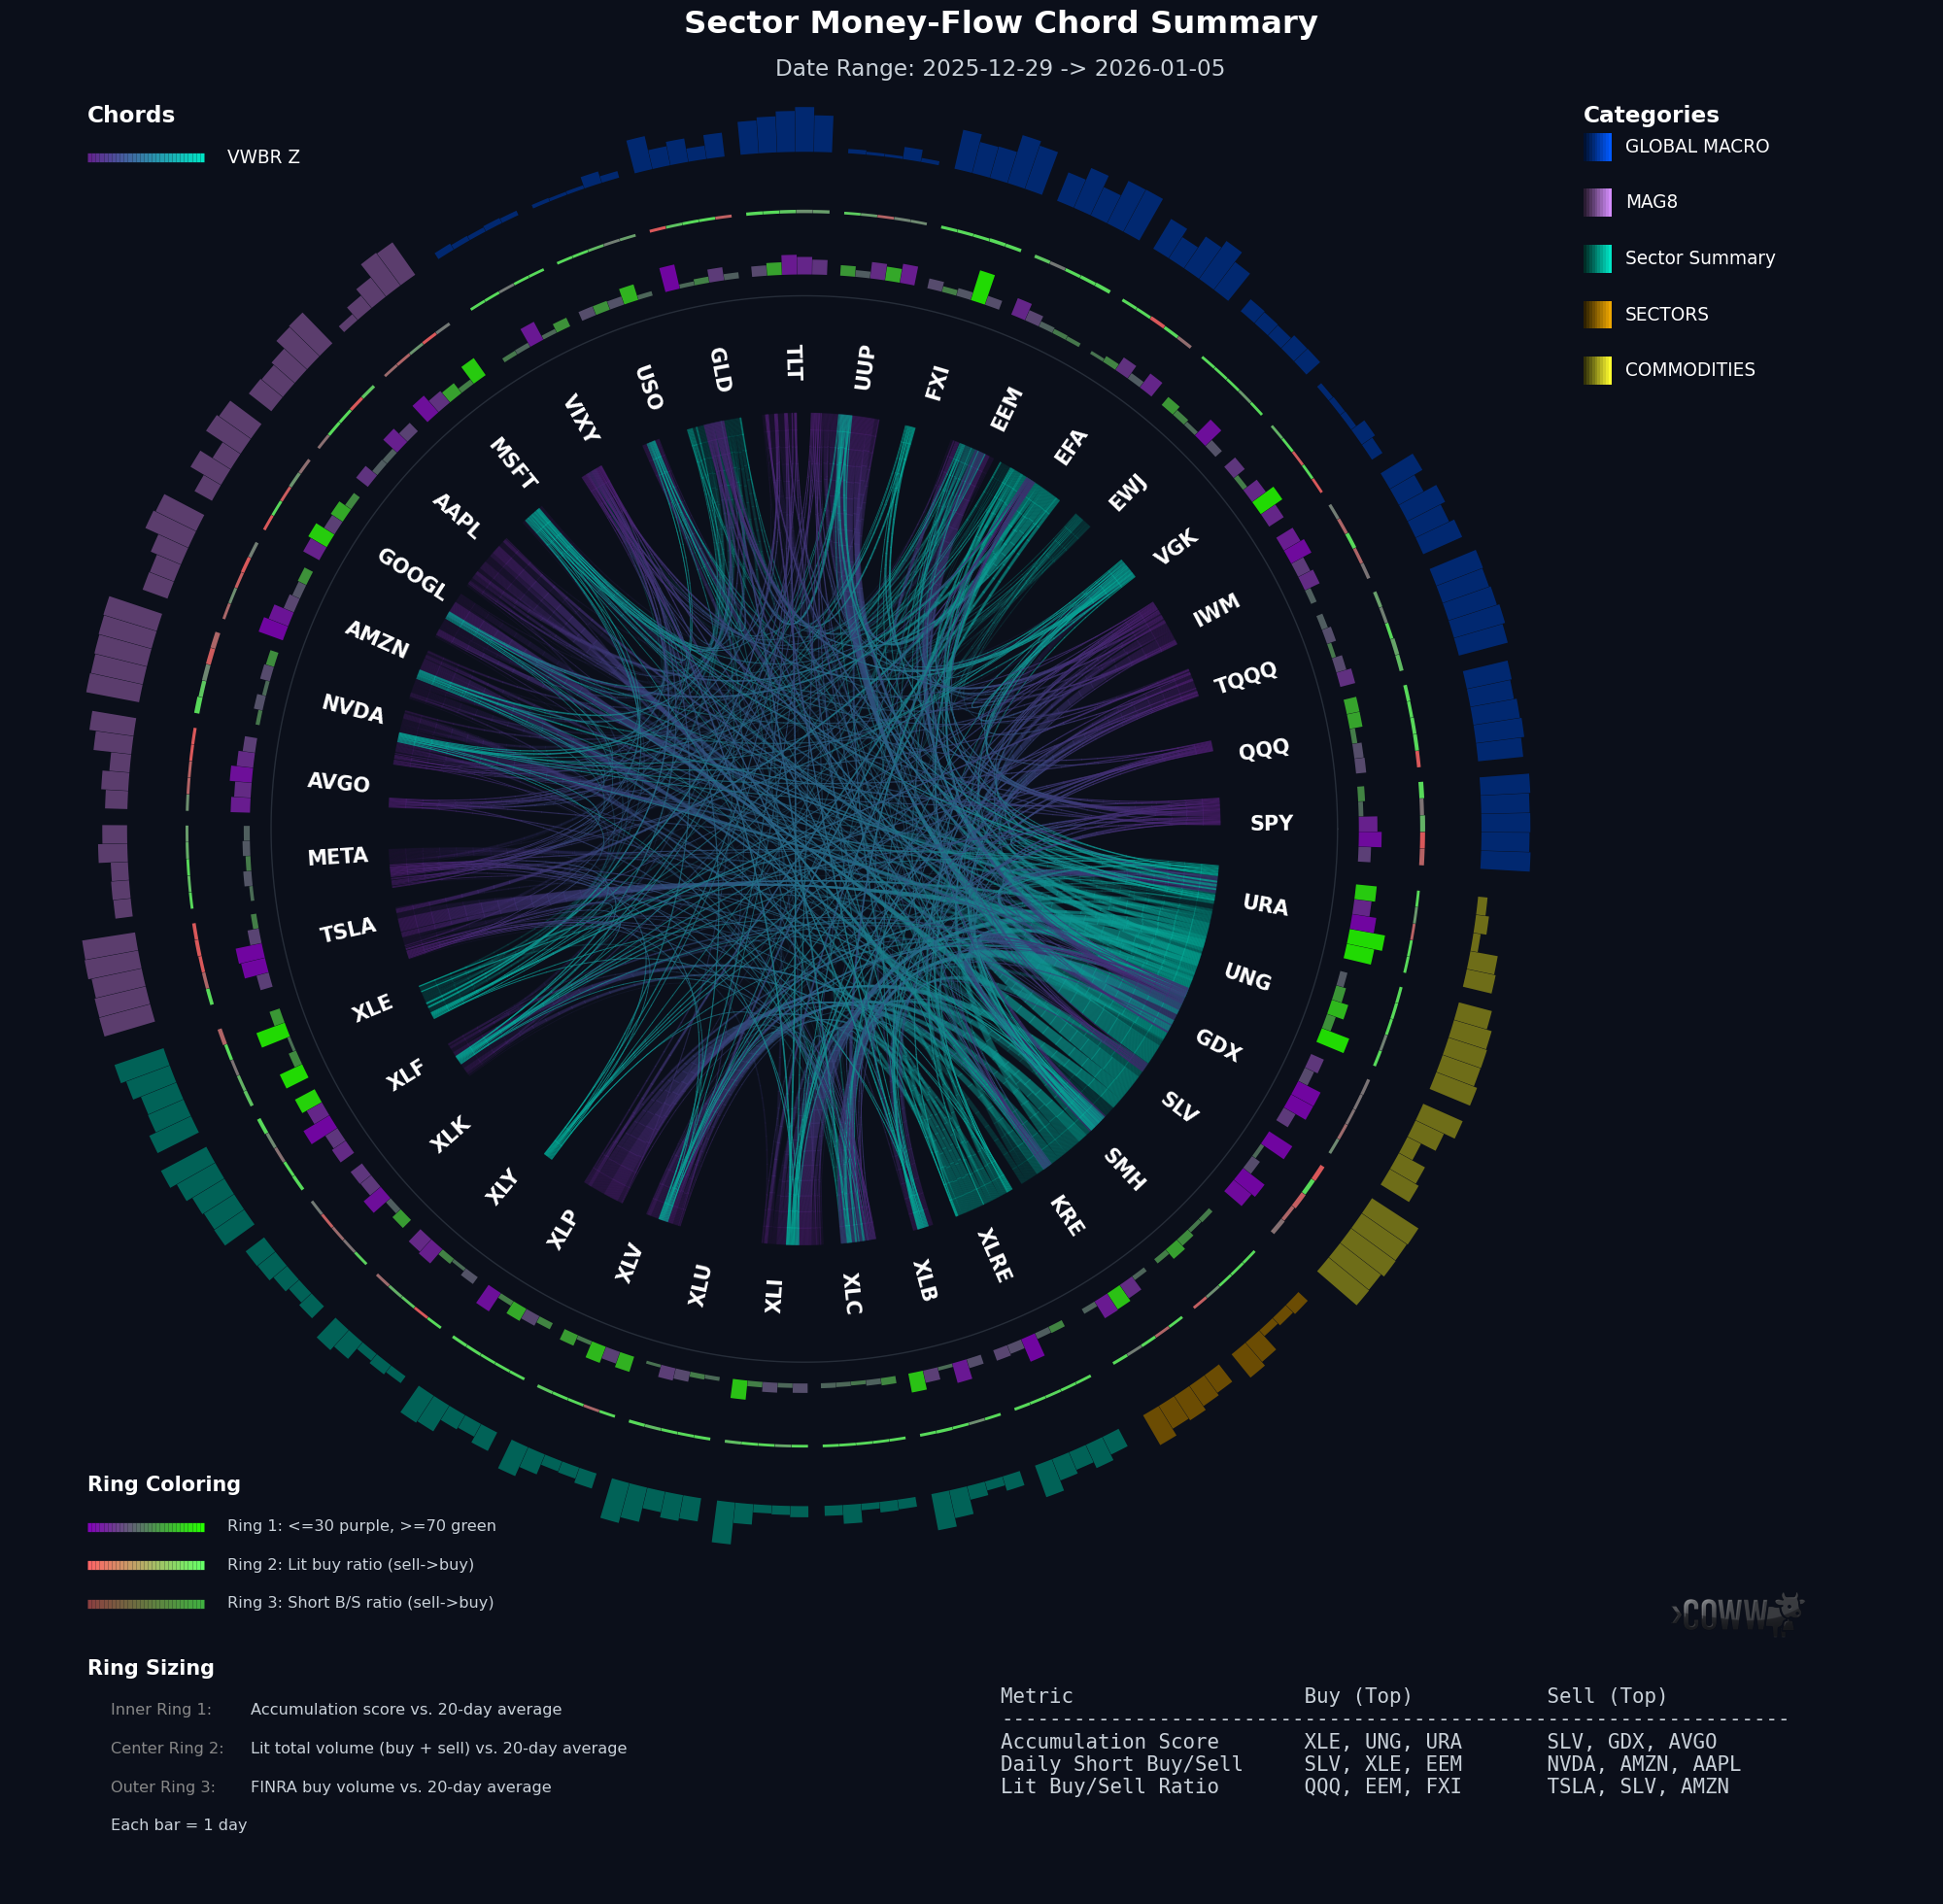

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Wedge, PathPatch, Rectangle
from matplotlib.path import Path
import os

BG_COLOR = '#0b0f1a'

CATEGORY_LABELS = {
    'GLOBAL_MACRO': 'GLOBAL MACRO',
    'MAG8': 'MAG8',
    'SECTOR_SUMMARY': 'Sector Summary',
    'SECTOR_CORE': 'SECTORS',
    'COMMODITIES': 'COMMODITIES',
    'SPECULATIVE': 'SPECULATIVE',
    'CRYPTO': 'CRYPTO',
}
CATEGORY_PALETTE = {
    'GLOBAL_MACRO': "#0059FF",
    'MAG8': "#D38CFA",
    'SECTOR_SUMMARY': "#00E4C5",
    'SECTOR_CORE': "#FAAF00F2",
    'COMMODITIES': "#FFFC2F",
    'SPECULATIVE': "#FF7A45",
    'CRYPTO': "#4CC9F0",
    'UNKNOWN': "#8F8E8E",
}

# Updated metric orders to include finra_buy for chords
CHORD_METRIC_ORDER = ['accum', 'short', 'lit', 'finra_buy', 'vwbr_z']
BAND_ORDER = ['lit', 'accum', 'short', 'finra_buy', 'vwbr_z']

# Ring metrics (different from chord metrics)
RING_METRIC_ORDER = ['accum', 'dark_lit', 'finra_buy']

METRIC_LABELS = {
    'accum': 'Accumulation',
    'short': 'Daily Short',
    'lit': 'Lit',
    'finra_buy': 'Finra Buy',
    'vwbr_z': 'VWBR Z',
    'dark_lit': 'Dark/Lit Ratio',
}

# Chord colors
METRIC_COLORS = {
    'accum': {'sell': "#8304B9", 'buy': "#26FF00"},
    'short': {'sell': "#280042", 'buy': "#00AEFF"},
    'lit': {'sell': "#FF0B0B", 'buy': "#1E7237"},
    'finra_buy': {'low': "#63238D", 'high': "#00E4C5"},  # Purple gradient for finra
    'vwbr_z': {'sell': "#63238D", 'buy': "#00E4C5"},
}

# Ring colors (new encodings)
RING_COLORS = {
    'accum': {'negative': "#8304B9", 'positive': "#26FF00"},  # Purple (-) to Green (+)
    'dark_lit': {'lit': "#4488FF", 'neutral': "#888888", 'dark': "#FF4444"},  # Blue-Gray-Red
    'finra_buy': {},  # Uses category colors dynamically
}


def blend_color(c1, c2, t=0.5):
    a = np.array(to_rgba(c1))
    b = np.array(to_rgba(c2))
    return a * (1 - t) + b * t


def soften_color(color, amount, base=BG_COLOR):
    return blend_color(color, base, max(0.0, min(1.0, amount)))


def darken_color(color, factor):
    """Darken a color by factor (0=black, 1=original)"""
    rgba = np.array(to_rgba(color))
    rgba[:3] = rgba[:3] * max(0.0, min(1.0, factor))
    return rgba


def add_gradient_curve(ax, points, color_start, color_end, lw, alpha):
    if len(points) < 2:
        return
    segments = np.stack([points[:-1], points[1:]], axis=1)
    c0 = np.array(to_rgba(color_start))
    c1 = np.array(to_rgba(color_end))
    t = np.linspace(0, 1, len(segments))[:, None]
    colors = c0 * (1 - t) + c1 * t
    colors[:, 3] = colors[:, 3] * alpha
    lc = LineCollection(segments, colors=colors, linewidths=lw, capstyle='round')
    ax.add_collection(lc)


def arc_points(a0, a1, r, n=None):
    count = n or CHORD_ARC_POINTS
    angles = np.linspace(a0, a1, count)
    return np.column_stack([r * np.cos(angles), r * np.sin(angles)])


def bezier_curve(p0, p1, p2, n=None):
    count = n or CHORD_CURVE_POINTS
    t = np.linspace(0, 1, count)[:, None]
    return (1 - t) ** 2 * p0 + 2 * (1 - t) * t * p1 + t ** 2 * p2


def ribbon_patch(a0, a1, b0, b1, r, color_start, color_end, alpha):
    arc1 = arc_points(a0, a1, r, n=16)
    arc2 = arc_points(b0, b1, r, n=16)
    curve1 = bezier_curve(arc1[-1], np.array([0.0, 0.0]), arc2[0], n=24)
    curve2 = bezier_curve(arc2[-1], np.array([0.0, 0.0]), arc1[0], n=24)
    poly = np.vstack([arc1, curve1, arc2, curve2])
    codes = [Path.MOVETO] + [Path.LINETO] * (len(poly) - 1)
    path = Path(poly, codes)
    mid = blend_color(color_start, color_end, 0.5)
    return PathPatch(path, facecolor=mid, edgecolor='none', alpha=alpha)


def gradient_fill_collection(a0, a1, b0, b1, r, color_start, color_end, alpha, steps=None):
    steps = steps or CHORD_GRADIENT_STEPS
    arc1 = arc_points(a0, a1, r, n=4)
    arc2 = arc_points(b0, b1, r, n=4)
    p_a0, p_a1 = arc1[0], arc1[-1]
    p_b0, p_b1 = arc2[0], arc2[-1]
    left = bezier_curve(p_a0, np.array([0.0, 0.0]), p_b0, n=steps + 1)
    right = bezier_curve(p_a1, np.array([0.0, 0.0]), p_b1, n=steps + 1)
    polys = []
    colors = []
    for i in range(steps):
        quad = np.vstack([left[i], left[i + 1], right[i + 1], right[i]])
        t = (i + 0.5) / steps
        color = blend_color(color_start, color_end, t)
        color[3] = color[3] * alpha
        polys.append(quad)
        colors.append(color)
    return PolyCollection(polys, facecolors=colors, edgecolors='none')


def draw_ribbon(ax, a0, a1, b0, b1, r, color_start, color_end, fill_alpha, line_alpha, lw):
    if USE_GRADIENT_FILL:
        clip = ribbon_patch(a0, a1, b0, b1, r, color_start, color_end, alpha=1.0)
        clip.set_facecolor('none')
        clip.set_edgecolor('none')
        ax.add_patch(clip)
        fill = gradient_fill_collection(a0, a1, b0, b1, r, color_start, color_end, fill_alpha)
        fill.set_clip_path(clip)
        ax.add_collection(fill)
    else:
        patch = ribbon_patch(a0, a1, b0, b1, r, color_start, color_end, alpha=fill_alpha)
        ax.add_patch(patch)
    mid_a = (a0 + a1) / 2
    mid_b = (b0 + b1) / 2
    p0 = np.array([r * np.cos(mid_a), r * np.sin(mid_a)])
    p2 = np.array([r * np.cos(mid_b), r * np.sin(mid_b)])
    curve = bezier_curve(p0, np.array([0.0, 0.0]), p2)
    add_gradient_curve(ax, curve, color_start, color_end, lw=lw, alpha=line_alpha)


def make_time_bins(dates, bins):
    if not dates:
        return []
    if bins is None or bins <= 0:
        return [dates]
    bins = min(bins, len(dates))
    split = np.array_split(dates, bins)
    return [list(s) for s in split if len(s)]


def compute_metric_totals(edges_df):
    totals = {}
    if edges_df is None or edges_df.empty:
        return totals
    for row in edges_df.itertuples():
        totals[row.source] = totals.get(row.source, 0.0) + row.flow
        totals[row.dest] = totals.get(row.dest, 0.0) + row.flow
    return totals


def filter_edges(edges_df):
    if edges_df is None or edges_df.empty:
        return edges_df
    df = edges_df.copy()
    if MAX_EDGES_PER_METRIC and MAX_EDGES_PER_METRIC > 0:
        df = df.nlargest(MAX_EDGES_PER_METRIC, 'flow')
    return df


def expand_edges(edges_df, splits):
    if edges_df is None or edges_df.empty:
        return edges_df
    if not splits or splits <= 1:
        return edges_df
    max_flow = edges_df['flow'].max() if 'flow' in edges_df.columns and not edges_df.empty else 0.0
    if max_flow <= 0:
        return edges_df
    rows = []
    for row in edges_df.itertuples():
        date_val = getattr(row, 'date', None)
        n = max(1, int(round(splits * (row.flow / max_flow))))
        if EDGE_RIBBON_MAX and EDGE_RIBBON_MAX > 0:
            n = min(n, EDGE_RIBBON_MAX)
        flow = row.flow / n
        for _ in range(n):
            rows.append({'source': row.source, 'dest': row.dest, 'flow': flow, 'date': date_val})
    return pd.DataFrame(rows)


def allocate_intervals(edges_df, band_map, metric_key, centered=True, center_offset=0.0):
    if edges_df is None or edges_df.empty:
        return []
    
    min_width_rad = RIBBON_MIN_WIDTH_RAD.get(metric_key, 0.003)
    
    out_counts = edges_df.groupby('source').size().to_dict()
    in_counts = edges_df.groupby('dest').size().to_dict()
    max_flow = edges_df['flow'].max() if not edges_df.empty else 1.0
    
    out_slot_info = {}
    in_slot_info = {}
    
    for ticker in ticker_order:
        spans = band_map.get(ticker, {}).get(metric_key)
        if not spans:
            continue
        
        out_range = spans['out']
        out_arc = out_range[1] - out_range[0]
        arc_center_out = (out_range[0] + out_range[1]) / 2 + center_offset
        n_out = out_counts.get(ticker, 0)
        if n_out > 0:
            total_gap = RIBBON_GAP_RAD * (n_out - 1)
            usable_out = max(0.0, out_arc - total_gap)
            slot_width_out = usable_out / n_out
            if slot_width_out < min_width_rad and n_out > 1:
                slot_width_out = min_width_rad
                total_gap = max(0.0, out_arc - n_out * slot_width_out)
            
            actual_gap = total_gap / max(1, n_out - 1) if n_out > 1 else 0.0
            total_width = n_out * slot_width_out + (n_out - 1) * actual_gap
            
            if centered:
                start_pos = arc_center_out - total_width / 2
            else:
                start_pos = out_range[0]
            
            out_slot_info[ticker] = {
                'slot_width': slot_width_out,
                'cursor': start_pos,
                'gap': actual_gap,
            }
        
        in_range = spans['in']
        in_arc = in_range[1] - in_range[0]
        arc_center_in = (in_range[0] + in_range[1]) / 2 + center_offset
        n_in = in_counts.get(ticker, 0)
        if n_in > 0:
            total_gap = RIBBON_GAP_RAD * (n_in - 1)
            usable_in = max(0.0, in_arc - total_gap)
            slot_width_in = usable_in / n_in
            if slot_width_in < min_width_rad and n_in > 1:
                slot_width_in = min_width_rad
                total_gap = max(0.0, in_arc - n_in * slot_width_in)
            
            actual_gap = total_gap / max(1, n_in - 1) if n_in > 1 else 0.0
            total_width = n_in * slot_width_in + (n_in - 1) * actual_gap
            
            if centered:
                start_pos = arc_center_in - total_width / 2
            else:
                start_pos = in_range[0]
            
            in_slot_info[ticker] = {
                'slot_width': slot_width_in,
                'cursor': start_pos,
                'gap': actual_gap,
            }
    
    intervals = []
    for row in edges_df.sort_values('flow', ascending=False).itertuples():
        date_val = getattr(row, 'date', None)
        src, dst, flow = row.source, row.dest, row.flow
        if src not in out_slot_info or dst not in in_slot_info:
            continue
        
        out_info = out_slot_info[src]
        in_info = in_slot_info[dst]
        
        if RIBBON_WIDTH_SCALE_BY_FLOW:
            flow_scale = (flow / max_flow) ** 0.5 if max_flow > 0 else 1.0
            out_width = max(min_width_rad * 0.5, out_info['slot_width'] * flow_scale)
            in_width = max(min_width_rad * 0.5, in_info['slot_width'] * flow_scale)
        else:
            out_width = out_info['slot_width']
            in_width = in_info['slot_width']
        
        a0 = out_info['cursor']
        a1 = a0 + out_width
        b0 = in_info['cursor']
        b1 = b0 + in_width
        
        out_info['cursor'] = a0 + out_info['slot_width'] + out_info['gap']
        in_info['cursor'] = b0 + in_info['slot_width'] + in_info['gap']
        
        if a1 > a0 and b1 > b0:
            intervals.append({'source': src, 'dest': dst, 'flow': flow, 'a0': a0, 'a1': a1, 'b0': b0, 'b1': b1, 'date': date_val})
    
    return intervals


def metric_visible(metric_key):
    if metric_key == "accum":
        return SHOW_ACCUM_FLOW
    if metric_key == "short":
        return SHOW_SHORT_NET_FLOW
    if metric_key == "lit":
        return SHOW_LIT_FLOW
    if metric_key == "finra_buy":
        return SHOW_FINRA_FLOW
    if metric_key == "vwbr_z":
        return SHOW_VWBR_Z
    return True


# Prepare chord metric datasets
accum_edges_plot = filter_edges(accum_edges_df)
short_edges_plot = filter_edges(short_edges_df)
lit_edges_plot = filter_edges(lit_edges_df)
finra_edges_plot = filter_edges(finra_edges_df) if 'finra_edges_df' in dir() else pd.DataFrame()
vwbr_z_edges_plot = filter_edges(vwbr_z_edges_df) if 'vwbr_z_edges_df' in dir() else pd.DataFrame()

def choose_time_edges(time_df, base_df):
    if SHOW_TIME_FADE_CHORDS and time_df is not None and not time_df.empty:
        return time_df
    return base_df

metric_edges = {
    'accum': choose_time_edges(accum_time_edges_df, accum_edges_plot),
    'short': choose_time_edges(short_time_edges_df, short_edges_plot),
    'lit': choose_time_edges(lit_time_edges_df, lit_edges_plot),
    'finra_buy': choose_time_edges(finra_time_edges_df, finra_edges_plot),
    'vwbr_z': choose_time_edges(vwbr_z_time_edges_df, vwbr_z_edges_plot),
}

metric_edges_draw = {m: expand_edges(metric_edges[m], EDGE_RIBBON_SPLITS) for m in CHORD_METRIC_ORDER}

metric_nets = {
    'accum': df_scores.set_index('ticker')['accum_centered'].to_dict() if 'accum_centered' in df_scores.columns else df_scores.set_index('ticker')['delta'].to_dict(),
    'short': df_volume.set_index('ticker')['short_net'].to_dict() if 'short_net' in df_volume.columns else {},
    'lit': df_volume.set_index('ticker')['lit_net'].to_dict() if 'lit_net' in df_volume.columns else {},
    'finra_buy': df_volume.set_index('ticker')['finra_buy_sum'].to_dict() if 'finra_buy_sum' in df_volume.columns else {},
    'vwbr_z': df_volume.set_index('ticker')['finra_buy_z_mean'].to_dict() if 'finra_buy_z_mean' in df_volume.columns else {},
}

df_accum_level = df_raw_full[df_raw_full['date'].isin(window_dates)][['ticker', 'date', 'accumulation_score']].copy()
if not df_accum_level.empty:
    df_accum_level = df_accum_level.rename(columns={'accumulation_score': 'value'})

# Ring metric daily data
# Query 20-day lookback for z-score normalization (all ring metrics)
RING_LOOKBACK_DAYS = 20
latest_date = pd.Timestamp(max(window_dates)) if window_dates else pd.Timestamp.now()
lookback_start = latest_date - pd.Timedelta(days=RING_LOOKBACK_DAYS + 10)

# 20-day stats for accumulation score
accum_stats = pd.DataFrame()
try:
    query_accum_lookback = f'''
        SELECT UPPER({quote_ident(info['ticker_col'])}) AS ticker,
               {date_expr} AS date,
               CAST(accumulation_score AS DOUBLE) AS accumulation_score
        FROM {quote_ident(info['table'])}
        WHERE UPPER({quote_ident(info['ticker_col'])}) IN ({placeholders})
        AND {date_expr} >= '{lookback_start.strftime('%Y-%m-%d')}'
    '''
    df_accum_lookback = pd.read_sql(query_accum_lookback, conn, params=ticker_list)
    if not df_accum_lookback.empty:
        accum_stats = df_accum_lookback.groupby('ticker')['accumulation_score'].agg(['mean', 'std']).reset_index()
        accum_stats.columns = ['ticker', 'accum_mean', 'accum_std']
except Exception as e:
    print(f"Warning: Could not load accum lookback: {e}")

# 20-day stats for dark_ratio (kept for backward compatibility)
dark_lit_stats = pd.DataFrame()
try:
    query_dark_lookback = f'''
        SELECT UPPER({quote_ident(volume_info['ticker_col'])}) AS ticker,
               {date_expr} AS date,
               {num_cast}({quote_ident(volume_info['otc_vol_col'])} AS DOUBLE) AS otc_volume,
               {num_cast}({quote_ident(volume_info['lit_total_col'])} AS DOUBLE) AS lit_total
        FROM {quote_ident(volume_info['table'])}
        WHERE UPPER({quote_ident(volume_info['ticker_col'])}) IN ({placeholders})
        AND {date_expr} >= '{lookback_start.strftime('%Y-%m-%d')}'
    '''
    df_dark_lookback = pd.read_sql(query_dark_lookback, conn, params=ticker_list)
    if not df_dark_lookback.empty:
        df_dark_lookback['total_volume'] = df_dark_lookback['otc_volume'] + df_dark_lookback['lit_total']
        df_dark_lookback['dark_ratio'] = df_dark_lookback['otc_volume'] / df_dark_lookback['total_volume'].replace(0, np.nan)
        df_dark_lookback['dark_ratio'] = df_dark_lookback['dark_ratio'].fillna(0.5)
        dark_lit_stats = df_dark_lookback.groupby('ticker')['dark_ratio'].agg(['mean', 'std']).reset_index()
        dark_lit_stats.columns = ['ticker', 'dark_ratio_mean', 'dark_ratio_std']
except Exception as e:
    print(f"Warning: Could not load dark_lit lookback: {e}")

# 20-day stats for lit volume (Ring 2 sizing)
lit_stats = pd.DataFrame()
try:
    query_lit_lookback = f'''
        SELECT UPPER({quote_ident(volume_info['ticker_col'])}) AS ticker,
               {date_expr} AS date,
               {num_cast}({quote_ident(volume_info['lit_total_col'])} AS DOUBLE) AS lit_total
        FROM {quote_ident(volume_info['table'])}
        WHERE UPPER({quote_ident(volume_info['ticker_col'])}) IN ({placeholders})
        AND {date_expr} >= '{lookback_start.strftime('%Y-%m-%d')}'
    '''
    df_lit_lookback = pd.read_sql(query_lit_lookback, conn, params=ticker_list)
    if not df_lit_lookback.empty:
        lit_stats = df_lit_lookback.groupby('ticker')['lit_total'].agg(['mean', 'std']).reset_index()
        lit_stats.columns = ['ticker', 'lit_vol_mean', 'lit_vol_std']
except Exception as e:
    print(f"Warning: Could not load lit lookback: {e}")

# 20-day stats for finra_buy and short_buy_sell_ratio
finra_stats = pd.DataFrame()
try:
    finra_cols = [f"{num_cast}({quote_ident(volume_info['finra_buy_col'])} AS DOUBLE) AS finra_buy"]
    if volume_info.get('short_buy_sell_ratio_col'):
        finra_cols.append(f"{num_cast}({quote_ident(volume_info['short_buy_sell_ratio_col'])} AS DOUBLE) AS short_buy_sell_ratio")
    query_finra_lookback = f'''
        SELECT UPPER({quote_ident(volume_info['ticker_col'])}) AS ticker,
               {date_expr} AS date,
               {', '.join(finra_cols)}
        FROM {quote_ident(volume_info['table'])}
        WHERE UPPER({quote_ident(volume_info['ticker_col'])}) IN ({placeholders})
        AND {date_expr} >= '{lookback_start.strftime('%Y-%m-%d')}'
    '''
    df_finra_lookback = pd.read_sql(query_finra_lookback, conn, params=ticker_list)
    if not df_finra_lookback.empty:
        agg_dict = {'finra_buy': ['mean', 'std']}
        if 'short_buy_sell_ratio' in df_finra_lookback.columns:
            agg_dict['short_buy_sell_ratio'] = ['mean', 'std']
        finra_stats = df_finra_lookback.groupby('ticker').agg(agg_dict).reset_index()
        finra_stats.columns = ['ticker'] + [f'{col}_{stat}' for col, stat in [('finra_buy', 'mean'), ('finra_buy', 'std')] + ([('sbsr', 'mean'), ('sbsr', 'std')] if 'short_buy_sell_ratio' in df_finra_lookback.columns else [])]
except Exception as e:
    print(f"Warning: Could not load finra lookback: {e}")

# Add short_buy_sell_ratio to df_finra_daily if available
if 'df_finra_daily' in dir() and 'df_vol_raw' in dir() and 'short_buy_sell_ratio' in df_vol_raw.columns:
    df_sbsr = df_vol_raw.groupby(['ticker', 'date'])['short_buy_sell_ratio'].mean().reset_index()
    df_finra_daily = df_finra_daily.merge(df_sbsr, on=['ticker', 'date'], how='left')

ring_metric_daily = {
    'accum': df_accum_level,
    'accum_stats': accum_stats,
    'dark_lit': df_dark_lit_daily if 'df_dark_lit_daily' in dir() else pd.DataFrame(),
    'dark_lit_stats': dark_lit_stats,
    'lit': df_lit_daily if 'df_lit_daily' in dir() else pd.DataFrame(),
    'lit_stats': lit_stats if 'lit_stats' in dir() else pd.DataFrame(),
    'finra_buy': df_finra_daily if 'df_finra_daily' in dir() else pd.DataFrame(),
    'finra_stats': finra_stats,
}

# Build ticker layout
grouped = {
    'GLOBAL_MACRO': [t for t in ticker_order if ticker_category.get(t) == 'GLOBAL_MACRO'],
    'MAG8': [t for t in ticker_order if ticker_category.get(t) == 'MAG8'],
    'SECTOR_SUMMARY': [t for t in ticker_order if ticker_category.get(t) == 'SECTOR_SUMMARY'],
    'SECTOR_CORE': [t for t in ticker_order if ticker_category.get(t) == 'SECTOR_CORE'],
    'COMMODITIES': [t for t in ticker_order if ticker_category.get(t) == 'COMMODITIES'],
    'SPECULATIVE': [t for t in ticker_order if ticker_category.get(t) == 'SPECULATIVE'],
    'CRYPTO': [t for t in ticker_order if ticker_category.get(t) == 'CRYPTO'],
}

metric_totals = {m: compute_metric_totals(metric_edges[m]) for m in CHORD_METRIC_ORDER}

total_nodes = sum(len(v) for v in grouped.values())
if total_nodes == 0:
    print('No nodes to plot.')
else:
    gap = math.radians(CATEGORY_GAP_DEG)
    total_gap = gap * len([g for g in grouped.values() if g])
    usable = 2 * math.pi - total_gap
    if usable <= 0:
        usable = 2 * math.pi
    step = usable / total_nodes
    arc_span = step * 0.85

    angles = {}
    spans = {}
    angle = 0.0
    for cat in ['GLOBAL_MACRO', 'MAG8', 'SECTOR_SUMMARY', 'SECTOR_CORE', 'COMMODITIES', 'SPECULATIVE', 'CRYPTO']:
        if not grouped[cat]:
            continue
        angle += gap / 2
        for t in grouped[cat]:
            angles[t] = angle
            spans[t] = (angle - arc_span / 2, angle + arc_span / 2)
            angle += step
        angle += gap / 2

    # Metric bands per ticker (for chords)
    band_map = {}
    for t, (a0, a1) in spans.items():
        max_span = (a1 - a0)
        chord_span = min(max_span, max_span * CHORD_ARC_FRACTION)
        chord_center = (a0 + a1) / 2
        band_gap = chord_span * BAND_GAP_FRAC

        if METRIC_BAND_MODE == 'proportional':
            weights = {m: metric_totals[m].get(t, 0.0) for m in BAND_ORDER}
            if sum(weights.values()) <= 0:
                weights = {m: 1.0 for m in BAND_ORDER}
        else:
            weights = {m: 1.0 for m in BAND_ORDER}

        total_w = sum(weights.values())
        if total_w <= 0:
            weights = {m: 1.0 for m in BAND_ORDER}
            total_w = sum(weights.values())

        available = chord_span - band_gap * max(len(BAND_ORDER) - 1, 0)
        if available <= 0:
            band_gap = 0.0
            available = chord_span

        lengths = {m: max(0.0, available * (weights[m] / total_w)) for m in BAND_ORDER}

        # Layout: follow BAND_ORDER
        total_len = sum(lengths.values()) + band_gap * max(len(BAND_ORDER) - 1, 0)
        start = chord_center - total_len / 2

        metric_spans = {}
        cursor = start
        for idx, m in enumerate(BAND_ORDER):
            m_len = lengths.get(m, 0.0)
            m_start = cursor
            m_end = m_start + m_len
            metric_spans[m] = (m_start, m_end)
            if idx < len(BAND_ORDER) - 1:
                cursor = m_end + band_gap
            else:
                cursor = m_end

        def band_slices(start, end):
            dir_gap = (end - start) * DIR_GAP_FRAC
            dir_gap = min(dir_gap, (end - start) * 0.5)
            if dir_gap < 0:
                dir_gap = 0.0
            mid = (start + end) / 2
            out_span = (start, mid - dir_gap / 2)
            in_span = (mid + dir_gap / 2, end)
            return {'out': out_span, 'in': in_span}

        band_map[t] = {m: band_slices(*metric_spans[m]) for m in BAND_ORDER}

    # Prepare intervals per metric with per-metric center offset
    metric_intervals = {}
    for m in CHORD_METRIC_ORDER:
        if not metric_visible(m):
            metric_intervals[m] = []
            continue
        offset = RIBBON_CENTER_OFFSET.get(m, 0.0)
        metric_intervals[m] = allocate_intervals(
            metric_edges_draw[m], band_map, m, 
            centered=RIBBON_CENTERED, 
            center_offset=offset
        )
    
    for m in CHORD_METRIC_ORDER:
        if metric_visible(m):
            offset = RIBBON_CENTER_OFFSET.get(m, 0.0)
            min_w = RIBBON_MIN_WIDTH_RAD.get(m, 0.003)
            print(f"{m}: {len(metric_intervals[m])} ribbons (centered={RIBBON_CENTERED}, offset={offset:.3f}, min_width={min_w:.4f})")

    # Time bins for outer ring
    window_dates_sorted = sorted(window_dates)
    time_bins = make_time_bins(window_dates_sorted, TIME_SLICE_BINS)
    time_bins = list(reversed(time_bins))

    time_fade_alpha = {}
    time_fade_min_date = None
    if SHOW_TIME_FADE_CHORDS and window_dates_sorted:
        time_fade_min_date = window_dates_sorted[0]
        count = len(window_dates_sorted)
        for idx, dt in enumerate(window_dates_sorted):
            t = idx / max(1, count - 1)
            t = t ** TIME_FADE_POWER
            time_fade_alpha[dt] = TIME_FADE_MIN_ALPHA + t * (TIME_FADE_MAX_ALPHA - TIME_FADE_MIN_ALPHA)

    # Pre-compute normalization for ring rendering
    ring_max_mag = {}
    ring_min_val = {}
    for m in RING_METRIC_ORDER:
        df_m = ring_metric_daily.get(m, pd.DataFrame())
        if df_m is None or df_m.empty:
            ring_max_mag[m] = 1.0
            ring_min_val[m] = 0.0
            continue
        if m == 'accum' and 'value' in df_m.columns and df_m['value'].notna().any():
            ring_max_mag[m] = float(df_m['value'].abs().max())
            ring_min_val[m] = 0.0  # For magnitude-based thickness
        elif m == 'dark_lit' and 'total_volume' in df_m.columns:
            ring_max_mag[m] = float(df_m['total_volume'].max()) if df_m['total_volume'].notna().any() else 1.0
            ring_min_val[m] = 0.0
        elif m == 'finra_buy' and 'finra_buy' in df_m.columns:
            vals = df_m['finra_buy'].dropna()
            if len(vals) > 0:
                ring_max_mag[m] = float(np.log10(vals.max() + 1)) if vals.max() > 0 else 1.0
                ring_min_val[m] = float(np.log10(vals.min() + 1)) if vals.min() > 0 else 0.0
            else:
                ring_max_mag[m] = 1.0
                ring_min_val[m] = 0.0
        else:
            ring_max_mag[m] = 1.0
            ring_min_val[m] = 0.0

    # Build bin value lookup for rings
    ring_bin_data = {m: {} for m in RING_METRIC_ORDER}
    for m in RING_METRIC_ORDER:
        df_m = ring_metric_daily.get(m, pd.DataFrame())
        if df_m is None or df_m.empty:
            for t in ticker_order:
                ring_bin_data[m][t] = [{'value': 0.0, 'extra': 0.0} for _ in time_bins]
            continue
        for t in ticker_order:
            data_by_bin = []
            for bin_dates in time_bins:
                mask = (df_m['ticker'] == t) & (df_m['date'].isin(bin_dates))
                if m == 'accum' and 'value' in df_m.columns:
                    val = float(df_m.loc[mask, 'value'].mean()) if mask.any() else 0.0
                    data_by_bin.append({'value': val, 'extra': 0.0})
                elif m == 'dark_lit':
                    # Ring 2 now shows Lit data: sizing=lit volume z-score, coloring=lit buy ratio
                    df_lit = ring_metric_daily.get('lit', pd.DataFrame())
                    if not df_lit.empty:
                        lit_mask = (df_lit['ticker'] == t) & (df_lit['date'].isin(bin_dates))
                        if lit_mask.any():
                            lit_vol = float(df_lit.loc[lit_mask, 'lit_total'].sum())
                            lit_buy_ratio = float(df_lit.loc[lit_mask, 'lit_buy_ratio'].mean())
                        else:
                            lit_vol = 0.0
                            lit_buy_ratio = 0.5
                    else:
                        lit_vol = 0.0
                        lit_buy_ratio = 0.5
                    data_by_bin.append({'value': lit_vol, 'extra': lit_buy_ratio})
                elif m == 'finra_buy' and 'finra_buy' in df_m.columns:
                    val = float(df_m.loc[mask, 'finra_buy'].sum()) if mask.any() else 0.0
                    # Pass short_buy_sell_ratio as extra for coloring (FINRA short sale buy/sell ratio)
                    if 'short_buy_sell_ratio' in df_m.columns and mask.any():
                        sbsr_val = float(df_m.loc[mask, 'short_buy_sell_ratio'].mean())
                    else:
                        sbsr_val = 1.0  # Neutral value (1.0 = equal buy/sell)
                    data_by_bin.append({'value': val, 'extra': sbsr_val})
                else:
                    data_by_bin.append({'value': 0.0, 'extra': 0.0})
            ring_bin_data[m][t] = data_by_bin

    # Start plot
    fig, ax = plt.subplots(figsize=FIGURE_SIZE, subplot_kw={'aspect': 'equal'})
    fig.patch.set_facecolor(BG_COLOR)
    ax.set_facecolor(BG_COLOR)
    ax.axis('off')
    main_left = PLOT_CENTER_X - MAIN_AX_SIZE / 2
    main_bottom = PLOT_CENTER_Y - MAIN_AX_SIZE / 2
    main_left = max(0.0, min(main_left, 1.0 - MAIN_AX_SIZE))
    main_bottom = max(0.0, min(main_bottom, 1.0 - MAIN_AX_SIZE))
    ax.set_position([main_left, main_bottom, MAIN_AX_SIZE, MAIN_AX_SIZE])

    theta = np.linspace(0, 2 * math.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), color='#39424e', lw=1.0, alpha=0.6)

    # Ring outer edge (ticker arc removed - Ring 3 shows category colors)
    ticker_outer = 1.02

    # Outer rings (NEW ENCODING: accum, dark_lit, finra_buy)
    if SHOW_VOLUME_RING:
        track_span = RING_BASE_THICKNESS + RING_THICKNESS_SCALE + RING_GAP
        for idx, m in enumerate(RING_METRIC_ORDER):
            inner_base = ticker_outer + 0.02 + idx * track_span
            max_mag = ring_max_mag.get(m, 1.0)
            
            for t, (a0, a1) in spans.items():
                bin_data = ring_bin_data[m].get(t, [])
                if not bin_data:
                    continue
                n_bins = len(bin_data)
                arc_len = a1 - a0
                slice_gap = arc_len * 0.02 / max(1, n_bins)
                slice_len = (arc_len - slice_gap * (n_bins - 1)) / n_bins if n_bins > 0 else arc_len
                cursor = a0
                for bd in bin_data:
                    val = bd['value']
                    extra = bd['extra']
                    
                    if m == 'accum':
                        # Ring 1: Sizing = 20-day z-score deviation, Coloring = accumulation thresholds
                        # Get 20-day stats for this ticker
                        df_astats = ring_metric_daily.get('accum_stats', pd.DataFrame())
                        if not df_astats.empty and t in df_astats['ticker'].values:
                            stats = df_astats[df_astats['ticker'] == t].iloc[0]
                            mean_val = stats['accum_mean']
                            std_val = stats['accum_std']
                            if std_val > 0:
                                z = abs(val - mean_val) / std_val
                                thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * min(z / 2.0, 1.0)
                            else:
                                thickness = RING_BASE_THICKNESS
                        else:
                            # Fallback: deviation from 50
                            deviation = abs(val - 50)
                            thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * (deviation / 50.0)

                        # Coloring: <=30 = max purple, >=70 = max green, 30-70 = blend
                        if val >= 70:
                            color = RING_COLORS['accum']['positive']  # Max green
                        elif val <= 30:
                            color = RING_COLORS['accum']['negative']  # Max purple
                        else:
                            # Blend based on position between 30-70
                            t_blend = (val - 30) / 40.0  # 0 at 30, 1 at 70
                            color = blend_color(RING_COLORS['accum']['negative'], RING_COLORS['accum']['positive'], t_blend)
                    
                    elif m == 'dark_lit':
                        # Ring 2: Sizing = Lit volume 20-day z-score, Coloring = Lit buy ratio
                        lit_vol = val  # lit_total from data
                        lit_buy_ratio = extra  # lit_buy_ratio from data

                        # Get 20-day lit volume stats for this ticker
                        df_lstats = ring_metric_daily.get('lit_stats', pd.DataFrame())
                        if not df_lstats.empty and t in df_lstats['ticker'].values:
                            stats = df_lstats[df_lstats['ticker'] == t].iloc[0]
                            mean_vol = stats['lit_vol_mean']
                            std_vol = stats['lit_vol_std']
                            if std_vol > 0 and lit_vol > 0:
                                z = (lit_vol - mean_vol) / std_vol
                                # Sizing: abs(z-score) deviation
                                thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * min(abs(z) / 2.0, 1.0)
                            else:
                                thickness = RING_BASE_THICKNESS
                        else:
                            # Fallback: use raw volume ratio
                            thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * (lit_vol / max_mag if max_mag > 0 else 0.0)

                        # Coloring: Lit buy ratio (0=all sells/red, 0.5=neutral/gray, 1=all buys/green)
                        # Typical range is 0.4-0.6, so use tighter scaling
                        normalized = (lit_buy_ratio - 0.4) / 0.2  # 0.4->0, 0.5->0.5, 0.6->1
                        normalized = max(0.0, min(1.0, normalized))

                        # Color: sell (red) to neutral (gray) to buy (green)
                        if normalized < 0.5:
                            color = blend_color('#FF6666', '#888888', normalized * 2)  # Red to gray
                        else:
                            color = blend_color('#888888', '#66FF66', (normalized - 0.5) * 2)  # Gray to green
                    
                    elif m == 'finra_buy':
                        # Ring 3: Sizing = 20-day z-score deviation, Coloring = short_buy_sell_ratio
                        # Get short_buy_sell_ratio from extra (passed from bin_data)
                        short_buy_sell_ratio = extra if extra is not None else 1.0

                        # Sizing: 20-day z-score deviation of finra_buy
                        df_fstats = ring_metric_daily.get('finra_stats', pd.DataFrame())
                        if not df_fstats.empty and t in df_fstats['ticker'].values:
                            stats = df_fstats[df_fstats['ticker'] == t].iloc[0]
                            mean_fb = stats.get('finra_buy_mean', 0)
                            std_fb = stats.get('finra_buy_std', 0)
                            if std_fb > 0 and val > 0:
                                z = abs(val - mean_fb) / std_fb
                                thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * min(z / 2.0, 1.0)
                            else:
                                thickness = RING_BASE_THICKNESS
                        else:
                            # Fallback to percentile
                            df_fb = ring_metric_daily.get('finra_buy', pd.DataFrame())
                            if not df_fb.empty and 'finra_buy' in df_fb.columns and val > 0:
                                all_vals = df_fb['finra_buy'].dropna()
                                if len(all_vals) > 1:
                                    pct = (all_vals < val).sum() / len(all_vals)
                                else:
                                    pct = 0.5
                                thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * pct
                            else:
                                thickness = RING_BASE_THICKNESS

                        # Coloring: short_buy_sell_ratio (buy/sell ratio from FINRA short sales)
                        # Ratio > 1 = more buying, < 1 = more selling
                        # Typical range: 0.5 to 2.0, center around 1.0
                        if short_buy_sell_ratio > 0:
                            # Log scale to handle wide range
                            log_ratio = np.log(short_buy_sell_ratio)
                            # Normalize: -0.5 to +0.5 -> 0 to 1
                            normalized = 0.5 + (log_ratio / 1.0)  # +/-0.5 log units = 0.6x to 1.6x
                            normalized = max(0.0, min(1.0, normalized))
                        else:
                            normalized = 0.5

                        # Color: low ratio (selling) = red, high ratio (buying) = green
                        cat_color = CATEGORY_PALETTE.get(ticker_category.get(t, 'UNKNOWN'), '#A0A0A0')
                        if normalized < 0.5:
                            # More selling = darker/reddish tint
                            brightness = 0.3 + 0.4 * (normalized * 2)
                            color = darken_color(cat_color, brightness)
                        else:
                            # More buying = brighter
                            brightness = 0.5 + 0.5 * ((normalized - 0.5) * 2)
                            color = darken_color(cat_color, brightness)
                    
                    else:
                        thickness = RING_BASE_THICKNESS
                        color = '#666666'
                    
                    wedge = Wedge(
                        (0, 0), inner_base + thickness, math.degrees(cursor), math.degrees(cursor + slice_len),
                        width=thickness,
                        facecolor=color, edgecolor='none', alpha=0.85,
                    )
                    ax.add_patch(wedge)
                    cursor += slice_len + slice_gap

    # Draw chords per metric
    for m in CHORD_METRIC_ORDER:
        if not metric_visible(m):
            continue
        intervals = metric_intervals[m]
        if not intervals:
            continue
        
        if m == 'finra_buy':
            raw_start = METRIC_COLORS[m]['low']
            raw_end = METRIC_COLORS[m]['high']
        else:
            raw_start = METRIC_COLORS[m]['sell']
            raw_end = METRIC_COLORS[m]['buy']
        color_start = soften_color(raw_start, CHORD_COLOR_SOFTEN)
        color_end = soften_color(raw_end, CHORD_COLOR_SOFTEN)
        max_flow = metric_edges[m]['flow'].max() if metric_edges[m] is not None and not metric_edges[m].empty else 1.0
        intervals_to_draw = intervals
        if SHOW_TIME_FADE_CHORDS and time_fade_alpha and time_fade_min_date is not None:
            intervals_to_draw = sorted(intervals, key=lambda e: e.get('date') or time_fade_min_date)
        for edge in intervals_to_draw:
            flow = edge['flow']
            lw = 0.6 + 2.2 * ((flow / max_flow) ** 0.6) if max_flow > 0 else 1.0
            alpha_factor = 1.0
            if SHOW_TIME_FADE_CHORDS and time_fade_alpha:
                edge_date = edge.get('date')
                if edge_date in time_fade_alpha:
                    alpha_factor = time_fade_alpha[edge_date]
            draw_ribbon(ax, edge['a0'], edge['a1'], edge['b0'], edge['b1'], CHORD_RADIUS, color_start, color_end, fill_alpha=CHORD_FILL_ALPHA * alpha_factor, line_alpha=CHORD_LINE_ALPHA * alpha_factor, lw=lw)

    # Ticker labels
    for t, ang in angles.items():
        x, y = math.cos(ang), math.sin(ang)
        r = CHORD_RADIUS + (ticker_outer - CHORD_RADIUS) * 0.4
        rot = math.degrees(ang)
        if math.pi / 2 < ang < 3 * math.pi / 2:
            rot += 180
        ax.text(r * x, r * y, t, color='#FFFFFF', fontsize=TICKER_FONTSIZE, fontweight='bold',
                ha='center', va='center', rotation=rot, rotation_mode='anchor')

    # Title and settings
    date_range = f"{window_dates_sorted[0]} -> {window_dates_sorted[-1]}" if window_dates_sorted else 'n/a'
    fig.text(0.55, 0.97, 'Sector Money-Flow Chord Summary', ha='center', va='top', color='white', fontsize=TITLE_FONTSIZE, fontweight='bold')
    fig.text(0.55, 0.945, f'Date Range: {date_range}', ha='center', va='top', color='#C9D1D9', fontsize=SUBTITLE_FONTSIZE)
    
    # Upper-left Legend (Chords only)
    leg = fig.add_axes([0.08, 0.75, 0.30, 0.18])
    leg.axis('off')
    leg.set_facecolor('none')
    leg.set_xlim(0, 1)
    leg.set_ylim(0, 1)

    y = 0.95
    leg.text(0.0, y, 'Chords', color='white', fontsize=LEGEND_TITLE_FONTSIZE, fontweight='bold', va='top')
    y -= 0.15

    chord_items = [
        ('accum', 'Accumulation', METRIC_COLORS['accum']['sell'], METRIC_COLORS['accum']['buy']),
        ('short', 'Short', METRIC_COLORS['short']['sell'], METRIC_COLORS['short']['buy']),
        ('lit', 'Lit', METRIC_COLORS['lit']['sell'], METRIC_COLORS['lit']['buy']),
        ('finra_buy', 'Finra Buy', METRIC_COLORS['finra_buy']['low'], METRIC_COLORS['finra_buy']['high']),
        ('vwbr_z', 'VWBR Z', METRIC_COLORS['vwbr_z']['sell'], METRIC_COLORS['vwbr_z']['buy']),
    ]
    for key, label, c_start, c_end in chord_items:
        if not metric_visible(key):
            continue
        xs = np.linspace(0.0, 0.20, 30)
        points = np.column_stack([xs, np.full_like(xs, y)])
        segments = np.stack([points[:-1], points[1:]], axis=1)
        c0 = np.array(to_rgba(c_start))
        c1 = np.array(to_rgba(c_end))
        t_arr = np.linspace(0, 1, len(segments))[:, None]
        colors = c0 * (1 - t_arr) + c1 * t_arr
        leg.add_collection(LineCollection(segments, colors=colors, linewidths=LEGEND_LINEWIDTH))
        leg.text(0.24, y, label, color='white', fontsize=LEGEND_LABEL_FONTSIZE, va='center')
        y -= 0.15

    # Bottom-left Ring Legend (Sizing + Coloring sections)
    ring_leg = fig.add_axes([0.08, 0.00, 0.6, 0.22])
    ring_leg.axis('off')
    ring_leg.set_facecolor('none')
    ring_leg.set_xlim(0, 1)
    ring_leg.set_ylim(0, 1)

    y = 0.98
    ring_leg.text(0.0, y, 'Ring Coloring', color='white', fontsize=RING_TITLE_FONTSIZE, fontweight='bold', va='top')
    y -= 0.12

    coloring_items = [
        ('Ring 1', '<=30 purple, >=70 green', RING_COLORS['accum']['negative'], RING_COLORS['accum']['positive']),
        ('Ring 2', 'Lit buy ratio (sell->buy)', '#FF6666', '#66FF66'),
        ('Ring 3', 'Short B/S ratio (sell->buy)', '#8B4040', '#40B040'),  # Dark red (selling) to bright green (buying)
    ]
    for ring, desc, c_start, c_end in coloring_items:
        if c_start and c_end:
            xs = np.linspace(0.0, 0.10, 30)
            points = np.column_stack([xs, np.full_like(xs, y)])
            segments = np.stack([points[:-1], points[1:]], axis=1)
            c0 = np.array(to_rgba(c_start))
            c1 = np.array(to_rgba(c_end))
            t_arr = np.linspace(0, 1, len(segments))[:, None]
            colors_arr = c0 * (1 - t_arr) + c1 * t_arr
            ring_leg.add_collection(LineCollection(segments, colors=colors_arr, linewidths=LEGEND_LINEWIDTH))
            ring_leg.text(0.12, y, f'{ring}: {desc}', color='#C9D1D9', fontsize=RING_LABEL_FONTSIZE, va='center')
        else:
            ring_leg.text(0.02, y, f'{ring}: {desc}', color='#C9D1D9', fontsize=RING_LABEL_FONTSIZE, va='center')
        y -= 0.09

    y -= 0.04
    ring_leg.text(0.0, y, 'Ring Sizing', color='white', fontsize=RING_TITLE_FONTSIZE, fontweight='bold', va='top')
    y -= 0.12

    sizing_items = [
        ('Inner Ring 1', 'Accumulation score vs. 20-day average'),
        ('Center Ring 2', 'Lit total volume (buy + sell) vs. 20-day average'),
        ('Outer Ring 3', 'FINRA buy volume vs. 20-day average'),
    ]
    for ring, desc in sizing_items:
        ring_leg.text(0.02, y, f'{ring}:', color='#888888', fontsize=RING_LABEL_FONTSIZE, va='center')
        ring_leg.text(0.14, y, desc, color='#C9D1D9', fontsize=RING_LABEL_FONTSIZE, va='center')
        y -= 0.09

    ring_leg.text(0.02, y, 'Each bar = 1 day', color='#C9D1D9', fontsize=RING_LABEL_FONTSIZE, va='center')
    y -= 0.09

    # Upper-right Category Legend (dynamic, gradient squares)
    present_categories = [cat for cat in ['GLOBAL_MACRO', 'MAG8', 'SECTOR_SUMMARY', 'SECTOR_CORE', 'COMMODITIES', 'SPECULATIVE', 'CRYPTO'] 
                         if grouped.get(cat)]
    
    if present_categories:
        cat_leg = fig.add_axes([0.85, 0.75, 0.18, 0.18])
        cat_leg.axis('off')
        cat_leg.set_facecolor('none')
        cat_leg.set_xlim(0, 1)
        cat_leg.set_ylim(0, 1)
        
        y = 0.95
        cat_leg.text(0.0, y, 'Categories', color='white', fontsize=LEGEND_TITLE_FONTSIZE, fontweight='bold', va='top')
        y -= 0.12
        
        for cat in present_categories:
            base_color = CATEGORY_PALETTE.get(cat, '#A0A0A0')
            dark_color = darken_color(base_color, 0.2)
            
            # Draw gradient square
            for i in range(10):
                t = i / 9.0
                color = blend_color(dark_color, base_color, t)
                rect = Rectangle((i * 0.008, y - 0.04), 0.008, 0.08, facecolor=color, edgecolor='none')
                cat_leg.add_patch(rect)
            
            cat_leg.text(0.12, y, CATEGORY_LABELS.get(cat, cat), color='white', fontsize=LEGEND_LABEL_FONTSIZE, va='center')
            y -= 0.16

    # Top inflow/outflow table
    def top_tickers(net_map, positive=True, k=3):
        if not net_map:
            return 'n/a'
        items = [(k, v) for k, v in net_map.items() if v is not None and np.isfinite(v)]
        if positive:
            items = sorted([x for x in items if x[1] > 0], key=lambda x: x[1], reverse=True)
        else:
            items = sorted([x for x in items if x[1] < 0], key=lambda x: x[1])
        return ', '.join([k for k, _ in items[:k]]) or 'n/a'

    table_rows = [
        ('Accumulation Score', top_tickers(metric_nets.get('accum', {}), True), top_tickers(metric_nets.get('accum', {}), False)),
        ('Daily Short Buy/Sell', top_tickers(metric_nets.get('short', {}), True), top_tickers(metric_nets.get('short', {}), False)),
        ('Lit Buy/Sell Ratio', top_tickers(metric_nets.get('lit', {}), True), top_tickers(metric_nets.get('lit', {}), False)),
    ]
    col1, col2, col3 = TABLE_COL1_WIDTH, TABLE_COL2_WIDTH, TABLE_COL3_WIDTH
    table_lines = [f"{'Metric':<{col1}}{'Buy (Top)':<{col2}}{'Sell (Top)':<{col3}}", '-' * (col1 + col2 + col3)]
    for label, buy_str, sell_str in table_rows:
        table_lines.append(f"{label:<{col1}}{buy_str:<{col2}}{sell_str:<{col3}}")
    fig.text(0.55, 0.05, '\n'.join(table_lines), ha='left', va='bottom', color='#C9D1D9', fontsize=TABLE_FONTSIZE, fontfamily='monospace', linespacing=1.2)
    
    # Watermark
    if os.path.exists(WATERMARK_PATH):
        watermark_img = plt.imread(WATERMARK_PATH)
        wm_h, wm_w = watermark_img.shape[:2]
        wm_aspect = (wm_h / wm_w) if wm_w else 1.0
        wm_w_frac = WATERMARK_WIDTH
        wm_h_frac = wm_w_frac * wm_aspect
        wm_left = 1 - wm_w_frac -0.03
        wm_bottom = 0.13
        wm_ax = fig.add_axes([wm_left, wm_bottom, wm_w_frac, wm_h_frac])
        wm_ax.axis('off')
        wm_ax.imshow(watermark_img, alpha=WATERMARK_ALPHA)

    plt.show()